In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

1 Page, each analysis consists of 3 images (HRL + 2 UL:
- \paragraph{Label Alignment vs Uniform Label}
- \paragraph{Input Alignment}

1 Page
- Comparison Input & Label alignment => 2 Images
- \subsection{Marginal Effect of Format Consistency} => 2 images / 1 Table / 1 Image?

1 Page, each analysis consists of 1-2 images (HRL + UL) => Retrieval
- \paragraph{Semantic Similarity Models}
- \paragraph{Cross-Lingual, Monolingual, and Translation Semantic Similarity}

1 Page Discussion & Conclusion
- \subsection{Is Cross-Lingual ICL Effective for Underrepresented Languages?} => 1 Image
- \subsection{Key Takeaways & What's next?} => Bullet points?

# ICL

In [2]:
dfs = []
for path in glob.glob('../metrics_icl/*.csv'):
    meta = path.split('/')[-1][:-4].split('_')
    dset_name, model_name = meta[1], meta[2]
    
    icl_meta = meta[3][4:]
    num_icl = int(icl_meta[-1])
    icl_type = icl_meta.split('-')[0]
    icl_idx = icl_meta[len(icl_type)+1:-2]
        
    iia_meta = meta[4][4:]
    num_iia = int(iia_meta[-1])
    iia_type = iia_meta.split('-')[0]
    iia_idx = iia_meta[len(iia_type)+1:-2]
    
    use_ioa = meta[5].split('-')[1]
    align_pos = meta[6].split('-')[1]
    
    # print(f'{dset_name} {model_name} {use_ioa}')
    # print(f'{icl_type} {num_icl} {icl_idx}')
    # print(f'{iia_type} {num_iia} {iia_idx}')
    
    # Load Metrics
    df = pd.read_csv(path)
    df = df.T
    df.columns = df.head(1).values[0]
    df = df.iloc[1:]

    # Inject Metadata
    df['model_name'] = model_name
    df['num_icl'] = num_icl
    df['icl_type'] = icl_type
    df['icl_idx'] = icl_idx
    df['num_iia'] = num_iia
    df['iia_type'] = iia_type
    df['iia_idx'] = iia_idx
    df['use_ioa'] = use_ioa
    df['align_pos'] = align_pos
    
    df['accuracy'] = pd.to_numeric(df['accuracy'])
    df['macro_f1'] = pd.to_numeric(df['macro_f1'])
    df['weighted_f1'] = pd.to_numeric(df['weighted_f1'])
    
    # Change Dataset Experiments
    df['dataset'] = df['dataset'].apply(lambda x: 'tweetsentimulti' if x == 'tweet_senti_multi' else x)
    
    # Remove Unused Experiments
    df = df.loc[(df['icl_type'] != 'cross') | (~df['icl_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['iia_type'] != 'cross') | (~df['iia_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['lang'] != 'eng'),:]
    dfs.append(df)
    
df = pd.concat(dfs)

In [3]:
df.to_csv('final_icl_results.csv', index=False)

In [4]:
df.loc[(df['icl_type'] == 'none') & (df['use_ioa'] == 'False'),:].groupby(
    ['dataset','model_name']
)[['accuracy', 'macro_f1', 'weighted_f1']].mean()

accuracy  macro_f1  weighted_f1
dataset             model_name                                 
americasnli         bloom-7b1   0.333378  0.167036     0.167013
                    xglm-7.5B   0.332413  0.220199     0.220164
americasnli-spa     bloom-7b1   0.332530  0.179661     0.179578
                    xglm-7.5B   0.335702  0.228254     0.228222
masakhanews         bloom-7b1   0.515066  0.461296     0.492946
                    xglm-7.5B   0.413908  0.375434     0.396556
nusatranslation     bloom-7b1   0.696898  0.615196     0.683840
                    xglm-7.5B   0.638056  0.567407     0.637430
nusatranslation-ind bloom-7b1   0.715509  0.588799     0.680807
                    xglm-7.5B   0.658472  0.591940     0.658154
tweetsentimulti     bloom-7b1   0.472989  0.425480     0.425480
                    xglm-7.5B   0.445320  0.382673     0.382673

In [5]:
df.groupby(['model_name', 'dataset']).size()

model_name  dataset            
bloom-7b1   americasnli            206
            americasnli-spa        206
            masakhanews            261
            nusatranslation        180
            nusatranslation-ind    180
            tweetsentimulti        182
xglm-7.5B   americasnli            204
            americasnli-spa        204
            masakhanews            261
            nusatranslation        180
            nusatranslation-ind    180
            tweetsentimulti        182
dtype: int64

In [6]:
for dset in df['dataset'].unique():
    print(dset)
    display(df.loc[
        (df['dataset'] == dset) & (df['model_name'] == 'bloom-7b1'),:
    ].sort_values(['dataset', 'icl_type', 'iia_type', 'use_ioa', 'align_pos'], ascending=False).reset_index(drop=True).groupby(
        ['dataset', 'icl_type', 'iia_type', 'icl_idx', 'iia_idx', 'num_icl', 'num_iia', 'use_ioa', 'align_pos']
    )[['accuracy', 'macro_f1', 'weighted_f1']].mean())

americasnli


accuracy  \
dataset     icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos             
americasnli cross    mono     sbert               unique$tf-idf$sbert 3       3       False   after      0.338214   
                                                                                              before     0.337908   
                                                                                      True    after      0.337226   
                                                                                              before     0.333553   
                     none     sbert               random              3       0       False   after      0.340602   
                                                                                      Target  after      0.343219   
                                                                                      True    after      0.331888   
            mono     none     random              random              3       0       False   after      0.329317   
                                                                                      Target  after      0.339872   
                              sbert               random              3       0       False   after      0.341287   
                                                                                      Target  after      0.356224   
                              tf-idf              random              3       0       False   after      0.348530   
                                                                                      Target  after      0.356216   
                              unique              random              3       0       False   after      0.359308   
                                                                                      Target  after      0.358228   
                              unique$tf-idf$sbert random              3       0       False   after      0.352495   
                                                                                      Target  after      0.340880   
            none     mono     random              sbert               0       3       False   after      0.333558   
                                                  unique$tf-idf$sbert 0       3       False   after      0.333289   
                                                                                      True    after      0.332887   
                     none     random              random              0       0       False   after      0.333289   
                                                                                      Target  after      0.336220   
                                                                                      True    after      0.333893   
            xpresso  none     sbert               none                3       0       False   after      0.341159   
                                                                                              before     0.339970   
                                                                                      Target  after      0.332221   
                              unique$tf-idf$sbert none                3       0       False   after      0.339822   
                                                                                              before     0.339569   
                                                                                      Target  after      0.333222   

                                                                                                         macro_f1  \
dataset     icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos             
americasnli cross    mono     sbert               unique$tf-idf$sbert 3       3       False   after      0.321246   
                                                                                              before     0.323490   
         

masakhanews


accuracy  \
dataset     icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos             
masakhanews cross    mono     sbert               unique$tf-idf$sbert 3       3       False   after      0.569597   
                                                                                              before     0.569989   
                                                                                      True    after      0.344674   
                     none     sbert               random              3       0       False   after      0.579809   
                                                                                      Target  after      0.396602   
                                                                                      True    after      0.307508   
            mono     none     random              random              3       0       False   after      0.572081   
                                                                                      Target  after      0.359786   
                              sbert               random              3       0       False   after      0.674767   
                                                                                      Target  after      0.620948   
                              tf-idf              random              3       0       False   after      0.684143   
                                                                                      Target  after      0.640226   
                              unique              random              3       0       False   after      0.683492   
                                                                                      Target  after      0.569394   
                              unique$tf-idf$sbert random              3       0       False   after      0.665432   
                                                                                      Target  after      0.577373   
            none     mono     random              sbert               0       3       False   after      0.493994   
                                                                                      True    after      0.278830   
                                                  unique$tf-idf$sbert 0       3       False   after      0.491112   
                                                                                      True    after      0.267773   
                     none     random              random              0       0       False   after      0.560091   
                                                                                      Target  after      0.273971   
                                                                                      True    after      0.273805   
            xpresso  none     sbert               none                3       0       False   after      0.534521   
                                                                                              before     0.528235   
                                                                                      Target  after      0.251156   
                              unique$tf-idf$sbert none                3       0       False   after      0.527119   
                                                                                              before     0.530685   
                                                                                      Target  after      0.251885   

                                                                                                         macro_f1  \
dataset     icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos             
masakhanews cross    mono     sbert               unique$tf-idf$sbert 3       3       False   after      0.527132   
                                                                                              before     0.530620   
         

nusatranslation


accuracy  \
dataset         icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos             
nusatranslation cross    mono     sbert               unique$tf-idf$sbert 3       3       False   after      0.603056   
                                                                                                  before     0.731250   
                                                                                          True    after      0.712639   
                                                                                                  before     0.713194   
                         none     sbert               random              3       0       False   after      0.735139   
                                                                                          Target  after      0.649444   
                                                                                          True    after      0.494444   
                mono     none     random              random              3       0       False   after      0.719028   
                                                                                          Target  after      0.643056   
                                  sbert               random              3       0       False   after      0.682500   
                                                                                          Target  after      0.678333   
                                  tf-idf              random              3       0       False   after      0.699722   
                                                                                          Target  after      0.707917   
                                  unique              random              3       0       False   after      0.697778   
                                                                                          Target  after      0.691944   
                                  unique$tf-idf$sbert random              3       0       False   after      0.674028   
                                                                                          Target  after      0.667917   
                none     mono     random              sbert               0       3       False   after      0.672778   
                                                                                          True    after      0.711389   
                                                      unique$tf-idf$sbert 0       3       False   after      0.727778   
                                                                                          True    after      0.447083   
                         none     random              random              0       0       False   after      0.690139   
                                                                                          Target  after      0.705278   
                                                                                          True    after      0.702083   
                xpresso  none     sbert               none                3       0       False   after      0.594306   
                                                                                                  before     0.594306   
                                                                                          Target  after      0.603194   
                                  unique$tf-idf$sbert none                3       0       False   after      0.455972   
                                                                                                  before     0.594306   
                                                                                          Target  after      0.455833   

                                                                                                             macro_f1  \
dataset         icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos        

tweetsentimulti


accuracy  \
dataset         icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos             
tweetsentimulti cross    mono     sbert               unique$tf-idf$sbert 3       3       False   after      0.533169   
                                                                                                  before     0.523974   
                                                                                          True    after      0.365353   
                                                                                                  before     0.360099   
                         none     sbert               random              3       0       False   after      0.533333   
                                                                                          Target  after      0.508539   
                                                                                          True    after      0.382266   
                mono     none     random              random              3       0       False   after      0.455665   
                                                                                          Target  after      0.419376   
                                  sbert               random              3       0       False   after      0.532841   
                                                                                          Target  after      0.519048   
                                  tf-idf              random              3       0       False   after      0.497701   
                                                                                          Target  after      0.458621   
                                  unique$tf-idf$sbert random              3       0       False   after      0.531691   
                none     mono     random              sbert               0       3       False   after      0.458621   
                                                                                          True    after      0.400000   
                         none     random              random              0       0       False   after      0.487356   
                                                                                          Target  after      0.403448   
                                                                                          True    after      0.378161   
                unique   none     count$tf-idf$sbert  random              3       0       False   after      0.483251   
                xpresso  none     sbert               none                3       0       False   after      0.466174   
                                                                                                  before     0.459934   
                                                                                          Target  after      0.391133   
                                  unique$tf-idf$sbert none                3       0       False   after      0.471593   
                                                                                                  before     0.458292   
                                                                                          Target  after      0.392611   

                                                                                                             macro_f1  \
dataset         icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos             
tweetsentimulti cross    mono     sbert               unique$tf-idf$sbert 3       3       False   after      0.528209   
                                                                                                  before     0.525806   
                                                                                          True    after      0.289090   
                                                                                                  before     0.2657

americasnli-spa


accuracy  \
dataset         icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos             
americasnli-spa cross    mono     sbert               unique$tf-idf$sbert 3       3       False   after      0.329442   
                                                                                                  before     0.329020   
                                                                                          True    after      0.343564   
                                                                                                  before     0.333549   
                         none     sbert               random              3       0       False   after      0.324766   
                                                                                          Target  after      0.335573   
                                                                                          True    after      0.328224   
                mono     none     random              random              3       0       False   after      0.324465   
                                                                                          Target  after      0.338898   
                                  sbert               random              3       0       False   after      0.341474   
                                                                                          Target  after      0.343548   
                                  tf-idf              random              3       0       False   after      0.338993   
                                                                                          Target  after      0.341225   
                                  unique              random              3       0       False   after      0.352262   
                                                                                          Target  after      0.362903   
                                  unique$tf-idf$sbert random              3       0       False   after      0.343403   
                                                                                          Target  after      0.332539   
                none     mono     random              sbert               0       3       False   after      0.333422   
                                                                                          True    after      0.335555   
                                                      unique$tf-idf$sbert 0       3       False   after      0.331549   
                         none     random              random              0       0       False   after      0.332618   
                                                                                          Target  after      0.332889   
                                                                                          True    after      0.334569   
                xpresso  none     sbert               none                3       0       False   after      0.336917   
                                                                                                  before     0.335311   
                                                                                          Target  after      0.332902   
                                  unique$tf-idf$sbert none                3       0       False   after      0.335311   
                                                                                                  before     0.335311   
                                                                                          Target  after      0.339576   

                                                                                                             macro_f1  \
dataset         icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos             
americasnli-spa cross    mono     sbert               unique$tf-idf$sbert 3       3       False   after      0.3095

nusatranslation-ind


accuracy  \
dataset             icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos             
nusatranslation-ind cross    mono     sbert               unique$tf-idf$sbert 3       3       False   after      0.727917   
                                                                                                      before     0.728194   
                                                                                              True    after      0.713889   
                                                                                                      before     0.708611   
                             none     sbert               random              3       0       False   after      0.735694   
                                                                                              Target  after      0.728333   
                                                                                              True    after      0.707222   
                    mono     none     random              random              3       0       False   after      0.723056   
                                                                                              Target  after      0.721806   
                                      sbert               random              3       0       False   after      0.697222   
                                                                                              Target  after      0.720139   
                                      tf-idf              random              3       0       False   after      0.708056   
                                                                                              Target  after      0.719722   
                                      unique              random              3       0       False   after      0.718472   
                                                                                              Target  after      0.707361   
                                      unique$tf-idf$sbert random              3       0       False   after      0.686806   
                                                                                              Target  after      0.692778   
                    none     mono     random              sbert               0       3       False   after      0.729722   
                                                                                              True    after      0.390278   
                                                          unique$tf-idf$sbert 0       3       False   after      0.730972   
                                                                                              True    after      0.703472   
                             none     random              random              0       0       False   after      0.685833   
                                                                                              Target  after      0.678750   
                                                                                              True    after      0.699028   
                    xpresso  none     sbert               none                3       0       False   after      0.734306   
                                                                                                      before     0.734306   
                                                                                              Target  after      0.685139   
                                      unique$tf-idf$sbert none                3       0       False   after      0.727917   
                                                                                                      before     0.727917   
                                                                                              Target  after      0.546111   

                                                                                                                

In [7]:
for dset in df['dataset'].unique():
    print(dset)
    display(df.loc[
        (df['dataset'] == dset) & (df['model_name'] == 'xglm-7.5B'),:
    ].sort_values(['dataset', 'icl_type', 'iia_type', 'use_ioa', 'align_pos'], ascending=False).reset_index(drop=True).groupby(
        ['dataset', 'icl_type', 'iia_type', 'icl_idx', 'iia_idx', 'num_icl', 'num_iia', 'use_ioa', 'align_pos']
    )[['accuracy', 'macro_f1', 'weighted_f1']].mean())

americasnli


accuracy  \
dataset     icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos             
americasnli cross    mono     random              unique$tf-idf$sbert 0       3       True    after      0.330900   
                              sbert               unique$tf-idf$sbert 3       3       False   before     0.342484   
                                                                                      True    after      0.330889   
                                                                                              before     0.340554   
                     none     sbert               random              3       0       False   after      0.343968   
                                                                                      Target  after      0.339884   
                                                                                      True    after      0.331549   
            mono     none     random              random              3       0       False   after      0.333581   
                                                                                      Target  after      0.331873   
                              sbert               random              3       0       False   after      0.348803   
                                                                                      Target  after      0.363556   
                              tf-idf              random              3       0       False   after      0.345837   
                                                                                      Target  after      0.350901   
                              unique              random              3       0       False   after      0.360128   
                                                                                      Target  after      0.350224   
                              unique$tf-idf$sbert random              3       0       False   after      0.345955   
                                                                                      Target  after      0.347547   
            none     mono     random              sbert               0       3       False   after      0.334504   
                                                                                      True    after      0.327546   
                                                  unique$tf-idf$sbert 0       3       False   after      0.328897   
                                                                                      True    after      0.327551   
                     none     random              random              0       0       False   after      0.333838   
                                                                                      Target  after      0.334223   
                                                                                      True    after      0.338231   
            xpresso  none     sbert               none                3       0       False   after      0.333954   
                                                                                              before     0.333954   
                                                                                      Target  after      0.332555   
                              unique$tf-idf$sbert none                3       0       False   after      0.333687   
                                                                                              before     0.333687   
                                                                                      Target  after      0.333555   

                                                                                                         macro_f1  \
dataset     icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos             
americasnli cross    mono     random              unique$tf-idf$sbert 0       3       True    after      0.241283   
         

masakhanews


accuracy  \
dataset     icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos             
masakhanews cross    mono     sbert               unique$tf-idf$sbert 3       3       False   before     0.576083   
                     none     sbert               random              3       0       False   after      0.582991   
                                                                                      Target  after      0.391624   
                                                                                      True    after      0.331273   
            mono     none     random              random              3       0       False   after      0.528734   
                                                                                      Target  after      0.353483   
                              sbert               random              3       0       False   after      0.648209   
                                                                                      Target  after      0.606429   
                              tf-idf              random              3       0       False   after      0.655084   
                                                                                      Target  after      0.598160   
                              unique              random              3       0       False   after      0.642176   
                                                                                      Target  after      0.526267   
                              unique$tf-idf$sbert random              3       0       False   after      0.632089   
                                                                                      Target  after      0.567123   
            none     mono     cross               unique$tf-idf$sbert 0       3       True    after      0.265669   
                              random              sbert               0       3       False   after      0.403072   
                                                                                      True    after      0.254365   
                                                  unique$tf-idf$sbert 0       3       False   after      0.409739   
                                                                                      True    after      0.251812   
                     none     random              random              0       0       False   after      0.428912   
                                                                                      Target  after      0.281030   
                                                                                      True    after      0.278920   
                     sbert    cross               unique$tf-idf$sbert 3       3       True    after      0.283061   
            xpresso  none     sbert               none                3       0       False   after      0.502325   
                                                                                              before     0.509933   
                                                                                      Target  after      0.240026   
                              unique$tf-idf$sbert none                3       0       False   after      0.508396   
                                                                                              before     0.509166   
                                                                                      Target  after      0.242473   

                                                                                                         macro_f1  \
dataset     icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos             
masakhanews cross    mono     sbert               unique$tf-idf$sbert 3       3       False   before     0.540183   
                     none     sbert               random              3       0       False   after      0.533107   
         

nusatranslation


accuracy  \
dataset         icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos             
nusatranslation cross    mono     random              unique$tf-idf$sbert 0       3       True    after      0.455972   
                                  sbert               unique$tf-idf$sbert 3       3       False   before     0.528333   
                                                                                          True    after      0.596667   
                                                                                                  before     0.534028   
                         none     sbert               random              3       0       False   after      0.617917   
                                                                                          Target  after      0.557222   
                                                                                          True    after      0.564722   
                mono     none     random              random              3       0       False   after      0.600972   
                                                                                          Target  after      0.550694   
                                  sbert               random              3       0       False   after      0.622361   
                                                                                          Target  after      0.485833   
                                  tf-idf              random              3       0       False   after      0.554444   
                                                                                          Target  after      0.550139   
                                  unique              random              3       0       False   after      0.610417   
                                                                                          Target  after      0.477778   
                                  unique$tf-idf$sbert random              3       0       False   after      0.619444   
                                                                                          Target  after      0.490833   
                none     mono     random              sbert               0       3       False   after      0.652778   
                                                                                          True    after      0.638333   
                                                      unique$tf-idf$sbert 0       3       False   after      0.667639   
                                                                                          True    after      0.630556   
                         none     random              random              0       0       False   after      0.593750   
                                                                                          Target  after      0.459306   
                                                                                          True    after      0.372361   
                xpresso  none     sbert               none                3       0       False   after      0.660278   
                                                                                                  before     0.608056   
                                                                                          Target  after      0.434444   
                                  unique$tf-idf$sbert none                3       0       False   after      0.608056   
                                                                                                  before     0.660278   
                                                                                          Target  after      0.434444   

                                                                                                             macro_f1  \
dataset         icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos        

tweetsentimulti


accuracy  \
dataset         icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos             
tweetsentimulti cross    mono     random              unique$tf-idf$sbert 0       3       True    after      0.400821   
                                  sbert               unique$tf-idf$sbert 3       3       False   before     0.462397   
                                                                                          True    before     0.409524   
                         none     sbert               random              3       0       False   after      0.458292   
                                                                                          Target  after      0.443350   
                                                                                          True    after      0.390476   
                mono     none     random              random              3       0       False   after      0.388342   
                                                                                          Target  after      0.391461   
                                  sbert               random              3       0       False   after      0.469294   
                                                                                          Target  after      0.465353   
                                  tf-idf              random              3       0       False   after      0.433990   
                                                                                          Target  after      0.429064   
                                  unique$tf-idf$sbert random              3       0       False   after      0.469787   
                none     mono     random              sbert               0       3       False   after      0.438588   
                                                                                          True    after      0.391626   
                                                      unique$tf-idf$sbert 0       3       False   after      0.444828   
                         none     random              random              0       0       False   after      0.452545   
                                                                                          Target  after      0.434975   
                                                                                          True    after      0.358785   
                unique   none     count$tf-idf$sbert  random              3       0       False   after      0.455993   
                xpresso  none     sbert               none                3       0       False   after      0.396388   
                                                                                                  before     0.396388   
                                                                                          Target  after      0.355172   
                                  unique$tf-idf$sbert none                3       0       False   after      0.391461   
                                                                                                  before     0.391133   
                                                                                          Target  after      0.358621   

                                                                                                             macro_f1  \
dataset         icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos             
tweetsentimulti cross    mono     random              unique$tf-idf$sbert 0       3       True    after      0.369803   
                                  sbert               unique$tf-idf$sbert 3       3       False   before     0.459308   
                                                                                          True    before     0.375668   
                         none     sbert               random              3       0       False   after      0.4578

americasnli-spa


accuracy  \
dataset         icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos             
americasnli-spa cross    mono     random              unique$tf-idf$sbert 0       3       True    after      0.340558   
                                  sbert               unique$tf-idf$sbert 3       3       False   before     0.339168   
                                                                                          True    after      0.338905   
                                                                                                  before     0.339900   
                         none     sbert               random              3       0       False   after      0.337560   
                                                                                          Target  after      0.341234   
                                                                                          True    after      0.343240   
                mono     none     random              random              3       0       False   after      0.337568   
                                                                                          Target  after      0.332564   
                                  sbert               random              3       0       False   after      0.338603   
                                                                                          Target  after      0.367220   
                                  tf-idf              random              3       0       False   after      0.350649   
                                                                                          Target  after      0.346902   
                                  unique              random              3       0       False   after      0.357980   
                                                                                          Target  after      0.339563   
                                  unique$tf-idf$sbert random              3       0       False   after      0.348257   
                                                                                          Target  after      0.339891   
                none     mono     random              sbert               0       3       False   after      0.337575   
                                                                                          True    after      0.333888   
                                                      unique$tf-idf$sbert 0       3       False   after      0.333292   
                                                                                          True    after      0.341569   
                         none     random              random              0       0       False   after      0.336238   
                                                                                          Target  after      0.336895   
                                                                                          True    after      0.339225   
                xpresso  none     sbert               none                3       0       False   after      0.341833   
                                                                                                  before     0.341302   
                                                                                          Target  after      0.343568   
                                  unique$tf-idf$sbert none                3       0       False   after      0.342909   
                                                                                                  before     0.340901   
                                                                                          Target  after      0.341568   

                                                                                                             macro_f1  \
dataset         icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos        

nusatranslation-ind


accuracy  \
dataset             icl_type iia_type icl_idx             iia_idx             num_icl num_iia use_ioa align_pos             
nusatranslation-ind cross    mono     random              unique$tf-idf$sbert 0       3       True    after      0.634583   
                                      sbert               unique$tf-idf$sbert 3       3       False   before     0.623333   
                                                                                              True    after      0.451667   
                                                                                                      before     0.432639   
                             none     sbert               random              3       0       False   after      0.625139   
                                                                                              Target  after      0.520556   
                                                                                              True    after      0.468889   
                    mono     none     random              random              3       0       False   after      0.594861   
                                                                                              Target  after      0.556250   
                                      sbert               random              3       0       False   after      0.547222   
                                                                                              Target  after      0.570000   
                                      tf-idf              random              3       0       False   after      0.562639   
                                                                                              Target  after      0.576111   
                                      unique              random              3       0       False   after      0.604444   
                                                                                              Target  after      0.561806   
                                      unique$tf-idf$sbert random              3       0       False   after      0.541250   
                                                                                              Target  after      0.490278   
                    none     mono     random              sbert               0       3       False   after      0.618750   
                                                                                              True    after      0.503194   
                                                          unique$tf-idf$sbert 0       3       False   after      0.679861   
                                                                                              True    after      0.636944   
                             none     random              random              0       0       False   after      0.676806   
                                                                                              Target  after      0.589444   
                                                                                              True    after      0.537222   
                    xpresso  none     sbert               none                3       0       False   after      0.369028   
                                                                                                      before     0.332500   
                                                                                              Target  after      0.327361   
                                      unique$tf-idf$sbert none                3       0       False   after      0.332500   
                                                                                                      before     0.369028   
                                                                                              Target  after      0.327361   

                                                                                                                

### Masakhanews

In [8]:
df.icl_idx.unique()

array(['random', 'tf-idf', 'sbert', 'unique$tf-idf$sbert',
       'count$tf-idf$sbert', 'unique', 'cross'], dtype=object)

In [9]:
df.loc[
    (df['num_icl'] == 3) & (df['use_ioa'] == 'False') &
    (df['dataset'] == 'masakhanews') & (df['icl_idx'].isin(['unique$tf-idf$sbert','sbert']))
,:].sort_values(['dataset', 'icl_type', 'icl_idx', 'iia_type', 'use_ioa'], ascending=False).reset_index(drop=True).groupby(
    ['dataset', 'lang', 'icl_type', 'icl_idx', 'use_ioa']
)[['accuracy', 'macro_f1', 'weighted_f1']].mean()

accuracy  macro_f1  \
dataset     lang icl_type icl_idx             use_ioa                       
masakhanews amh  cross    sbert               False    0.491489  0.482126   
                 mono     sbert               False    0.613032  0.610969   
                          unique$tf-idf$sbert False    0.648936  0.647726   
                 xpresso  sbert               False    0.229388  0.125712   
                          unique$tf-idf$sbert False    0.230053  0.127403   
            hau  cross    sbert               False    0.396546  0.382939   
                 mono     sbert               False    0.616170  0.592915   
                          unique$tf-idf$sbert False    0.527473  0.502732   
                 xpresso  sbert               False    0.494898  0.468693   
                          unique$tf-idf$sbert False    0.496075  0.467749   
            ibo  cross    sbert               False    0.675897  0.658155   
                 mono     sbert               False    0.747436  0.727405   
                          unique$tf-idf$sbert False    0.738462  0.707377   
                 xpresso  sbert               False    0.714744  0.692015   
                          unique$tf-idf$sbert False    0.720513  0.697134   
            lug  cross    sbert               False    0.520179  0.383003   
                 mono     sbert               False    0.506726  0.390026   
                          unique$tf-idf$sbert False    0.477578  0.362220   
                 xpresso  sbert               False    0.484305  0.352424   
                          unique$tf-idf$sbert False    0.480942  0.347142   
            pcm  cross    sbert               False    0.879344  0.845312   
                 mono     sbert               False    0.926230  0.911161   
                          unique$tf-idf$sbert False    0.927869  0.908959   
                 xpresso  sbert               False    0.602459  0.463236   
                          unique$tf-idf$sbert False    0.609836  0.468907   
            sna  cross    sbert               False    0.488347  0.465399   
                 mono     sbert               False    0.635501  0.635691   
                          unique$tf-idf$sbert False    0.601626  0.606272   
                 xpresso  sbert               False    0.557588  0.536769   
                          unique$tf-idf$sbert False    0.542683  0.520214   
            swa  cross    sbert               False    0.650840  0.591822   
                 mono     sbert               False    0.736345  0.676491   
                          unique$tf-idf$sbert False    0.727941  0.675814   
                 xpresso  sbert               False    0.441176  0.405892   
                          unique$tf-idf$sbert False    0.439076  0.405609   
            xho  cross    sbert               False    0.411448  0.328282   
                 mono     sbert               False    0.422559  0.328057   
                          unique$tf-idf$sbert False    0.466330  0.402650   
                 xpresso  sbert               False    0.473906  0.353724   
                          unique$tf-idf$sbert False    0.476431  0.353658   
            yor  cross    sbert               False    0.667153  0.662453   
                 mono     sbert               False    0.749392  0.756709   
                          unique$tf-idf$sbert False    0.722628  0.727261   
                 xpresso  sbert               False    0.670316  0.664384   
                          unique$tf-idf$sbert False    0.673966  0.668029   

                                                       weighted_f1  
dataset     lang icl_type icl_idx             use_ioa               
masakhanews amh  cross    sbert               False       0.484902  
                 mono     sbert               False       0.612956  
                          unique$tf-idf$sbert False       0.649282  
                 xpresso  sbert               False       0.115395  
                     

### AmericasNLI

In [10]:
df.loc[
    (df['num_icl'] == 3) & (df['use_ioa'] == 'False') &
    (df['dataset'] == 'americasnli') & (df['icl_idx'].isin(['unique$tf-idf$sbert','sbert']))
,:].sort_values(['dataset', 'icl_type', 'icl_idx', 'iia_type', 'use_ioa'], ascending=False).reset_index(drop=True).groupby(
    ['dataset', 'lang', 'icl_type', 'icl_idx', 'use_ioa']
)[['accuracy', 'macro_f1', 'weighted_f1']].mean()

accuracy  macro_f1  \
dataset     lang icl_type icl_idx             use_ioa                       
americasnli aym  cross    sbert               False    0.358133  0.337620   
                 mono     sbert               False    0.356667  0.341087   
                          unique$tf-idf$sbert False    0.365333  0.351169   
                 xpresso  sbert               False    0.337000  0.209699   
                          unique$tf-idf$sbert False    0.337000  0.209699   
            bzd  cross    sbert               False    0.352000  0.337502   
                 mono     sbert               False    0.346000  0.305539   
                          unique$tf-idf$sbert False    0.358000  0.332203   
                 xpresso  sbert               False    0.335667  0.204915   
                          unique$tf-idf$sbert False    0.335667  0.204915   
            cni  cross    sbert               False    0.347733  0.320720   
                 mono     sbert               False    0.328667  0.305732   
                          unique$tf-idf$sbert False    0.366000  0.347813   
                 xpresso  sbert               False    0.334667  0.199736   
                          unique$tf-idf$sbert False    0.334667  0.199736   
            gn   cross    sbert               False    0.349600  0.334928   
                 mono     sbert               False    0.375333  0.357137   
                          unique$tf-idf$sbert False    0.336667  0.324278   
                 xpresso  sbert               False    0.339000  0.205885   
                          unique$tf-idf$sbert False    0.339333  0.205732   
            hch  cross    sbert               False    0.334133  0.317317   
                 mono     sbert               False    0.339333  0.314827   
                          unique$tf-idf$sbert False    0.348000  0.330435   
                 xpresso  sbert               False    0.333667  0.206996   
                          unique$tf-idf$sbert False    0.333667  0.206996   
            nah  cross    sbert               False    0.325474  0.309451   
                 mono     sbert               False    0.348238  0.325607   
                          unique$tf-idf$sbert False    0.336043  0.316566   
                 xpresso  sbert               False    0.335027  0.208222   
                          unique$tf-idf$sbert False    0.335027  0.208222   
            oto  cross    sbert               False    0.329144  0.313974   
                 mono     sbert               False    0.330214  0.289057   
                          unique$tf-idf$sbert False    0.328209  0.287944   
                 xpresso  sbert               False    0.336898  0.226958   
                          unique$tf-idf$sbert False    0.330882  0.209858   
            quy  cross    sbert               False    0.340000  0.329285   
                 mono     sbert               False    0.355333  0.336368   
                          unique$tf-idf$sbert False    0.374667  0.364224   
                 xpresso  sbert               False    0.337333  0.209633   
                          unique$tf-idf$sbert False    0.337333  0.209633   
            shp  cross    sbert               False    0.322133  0.305716   
                 mono     sbert               False    0.324000  0.293650   
                          unique$tf-idf$sbert False    0.346000  0.315921   
                 xpresso  sbert               False    0.339333  0.208710   
                          unique$tf-idf$sbert False    0.339333  0.208710   
            tar  cross    sbert               False    0.348000  0.333652   
                 mono     sbert               False    0.346667  0.320151   
                          unique$tf-idf$sbert False    0.333333  0.316114   
                 xpresso  sbert               False    0.344000  0.205759   
                          unique$tf-idf$sbert False    0.344000  0.205759   

                                                  

# AmericasNLI Spa

In [11]:
df.loc[
    (df['num_icl'] == 3) & (df['use_ioa'] == 'False') &
    (df['dataset'] == 'americasnli-spa') & (df['icl_idx'].isin(['unique$tf-idf$sbert','sbert']))
,:].sort_values(['dataset', 'icl_type', 'icl_idx', 'iia_type', 'use_ioa'], ascending=False).reset_index(drop=True).groupby(
    ['dataset', 'lang', 'icl_type', 'icl_idx', 'use_ioa']
)[['accuracy', 'macro_f1', 'weighted_f1']].mean()

accuracy  macro_f1  \
dataset         lang icl_type icl_idx             use_ioa                       
americasnli-spa aym  cross    sbert               False    0.336267  0.305443   
                     mono     sbert               False    0.342667  0.313906   
                              unique$tf-idf$sbert False    0.360000  0.352003   
                     xpresso  sbert               False    0.332333  0.251147   
                              unique$tf-idf$sbert False    0.337667  0.248727   
                bzd  cross    sbert               False    0.325600  0.303634   
                     mono     sbert               False    0.346667  0.313490   
                              unique$tf-idf$sbert False    0.336667  0.326270   
                     xpresso  sbert               False    0.336667  0.255480   
                              unique$tf-idf$sbert False    0.337333  0.248823   
                cni  cross    sbert               False    0.334400  0.314341   
                     mono     sbert               False    0.340000  0.311724   
                              unique$tf-idf$sbert False    0.358667  0.351498   
                     xpresso  sbert               False    0.336333  0.267330   
                              unique$tf-idf$sbert False    0.337667  0.259692   
                gn   cross    sbert               False    0.334933  0.304565   
                     mono     sbert               False    0.352667  0.327621   
                              unique$tf-idf$sbert False    0.364667  0.351893   
                     xpresso  sbert               False    0.342000  0.264313   
                              unique$tf-idf$sbert False    0.340667  0.256522   
                hch  cross    sbert               False    0.329067  0.290433   
                     mono     sbert               False    0.316667  0.294854   
                              unique$tf-idf$sbert False    0.342667  0.338325   
                     xpresso  sbert               False    0.340000  0.268022   
                              unique$tf-idf$sbert False    0.341333  0.257847   
                nah  cross    sbert               False    0.336585  0.307817   
                     mono     sbert               False    0.345528  0.316736   
                              unique$tf-idf$sbert False    0.339431  0.323682   
                     xpresso  sbert               False    0.341463  0.280648   
                              unique$tf-idf$sbert False    0.343496  0.275026   
                oto  cross    sbert               False    0.348128  0.331019   
                     mono     sbert               False    0.320187  0.296425   
                              unique$tf-idf$sbert False    0.326203  0.317363   
                     xpresso  sbert               False    0.355281  0.292177   
                              unique$tf-idf$sbert False    0.345254  0.273442   
                quy  cross    sbert               False    0.315467  0.290511   
                     mono     sbert               False    0.359333  0.327247   
                              unique$tf-idf$sbert False    0.342667  0.326014   
                     xpresso  sbert               False    0.334667  0.254873   
                              unique$tf-idf$sbert False    0.333333  0.247201   
                shp  cross    sbert               False    0.337867  0.325305   
                     mono     sbert               False    0.344667  0.319686   
                              unique$tf-idf$sbert False    0.342000  0.335250   
                     xpresso  sbert               False    0.335667  0.260698   
                              unique$tf-idf$sbert False    0.336667  0.252624   
                tar  cross    sbert               False    0.321600  0.310008   
                     mono     sbert               False    0.332000  0.300999   
                              unique$tf-idf$sbert False    0.345333  0.332812   
         

### NusaTranslation

In [12]:
df.loc[
    (df['num_icl'] == 3) & (df['use_ioa'] == 'False') &
    (df['dataset'] == 'nusatranslation') & (df['icl_idx'].isin(['unique$tf-idf$sbert','sbert']))
,:].sort_values(['dataset', 'icl_type', 'icl_idx', 'iia_type', 'use_ioa'], ascending=False).reset_index(drop=True).groupby(
    ['dataset', 'lang', 'icl_type', 'icl_idx', 'use_ioa']
)[['accuracy', 'macro_f1', 'weighted_f1']].mean()

accuracy  macro_f1  \
dataset         lang icl_type icl_idx             use_ioa                       
nusatranslation btk  cross    sbert               False    0.607833  0.532323   
                     mono     sbert               False    0.605000  0.546767   
                              unique$tf-idf$sbert False    0.607500  0.548292   
                     xpresso  sbert               False    0.571250  0.547860   
                              unique$tf-idf$sbert False    0.533750  0.504273   
                jav  cross    sbert               False    0.668667  0.597925   
                     mono     sbert               False    0.668333  0.599491   
                              unique$tf-idf$sbert False    0.671667  0.605970   
                     xpresso  sbert               False    0.631875  0.612767   
                              unique$tf-idf$sbert False    0.595625  0.576864   
                mad  cross    sbert               False    0.614500  0.542294   
                     mono     sbert               False    0.622917  0.558990   
                              unique$tf-idf$sbert False    0.606250  0.549628   
                     xpresso  sbert               False    0.571667  0.548230   
                              unique$tf-idf$sbert False    0.537292  0.507527   
                mak  cross    sbert               False    0.592500  0.506108   
                     mono     sbert               False    0.616250  0.558440   
                              unique$tf-idf$sbert False    0.607083  0.547610   
                     xpresso  sbert               False    0.534583  0.511523   
                              unique$tf-idf$sbert False    0.500833  0.468390   
                min  cross    sbert               False    0.698500  0.629752   
                     mono     sbert               False    0.719167  0.645345   
                              unique$tf-idf$sbert False    0.712917  0.646471   
                     xpresso  sbert               False    0.701875  0.671166   
                              unique$tf-idf$sbert False    0.671875  0.643891   
                sun  cross    sbert               False    0.676833  0.601847   
                     mono     sbert               False    0.682917  0.620438   
                              unique$tf-idf$sbert False    0.675000  0.611183   
                     xpresso  sbert               False    0.674167  0.650319   
                              unique$tf-idf$sbert False    0.638542  0.617311   

                                                           weighted_f1  
dataset         lang icl_type icl_idx             use_ioa               
nusatranslation btk  cross    sbert               False       0.595474  
                     mono     sbert               False       0.612208  
                              unique$tf-idf$sbert False       0.614716  
                     xpresso  sbert               False       0.579020  
                              unique$tf-idf$sbert False       0.521247  
                jav  cross    sbert               False       0.661746  
                     mono     sbert               False       0.667770  
                              unique$tf-idf$sbert False       0.671987  
                     xpresso  sbert               False       0.644541  
                              unique$tf-idf$sbert False       0.599650  
                mad  cross    sbert               False       0.604787  
                     mono     sbert               False       0.626001  
                              unique$tf-idf$sbert False       0.613445  
                     xpresso  sbert               False       0.576093  
                              unique$tf-idf$sbert False       0.522458  
                mak  cross    sbert               False       0.570056  
                     mono     sbert               False       0.620834  
                              unique$tf-idf$sbert False       0.611627  
      

## Nusa Translation-Ind

In [13]:
df.loc[
    (df['num_icl'] == 3) & (df['use_ioa'] == 'False') &
    (df['dataset'] == 'nusatranslation-ind') & (df['icl_idx'].isin(['unique$tf-idf$sbert','sbert']))
,:].sort_values(['dataset', 'icl_type', 'icl_idx', 'iia_type', 'use_ioa'], ascending=False).reset_index(drop=True).groupby(
    ['dataset', 'lang', 'icl_type', 'icl_idx', 'use_ioa']
)[['accuracy', 'macro_f1', 'weighted_f1']].mean()

accuracy  \
dataset             lang icl_type icl_idx             use_ioa             
nusatranslation-ind btk  cross    sbert               False    0.674167   
                         mono     sbert               False    0.558333   
                                  unique$tf-idf$sbert False    0.560000   
                         xpresso  sbert               False    0.532292   
                                  unique$tf-idf$sbert False    0.520625   
                    jav  cross    sbert               False    0.704833   
                         mono     sbert               False    0.664167   
                                  unique$tf-idf$sbert False    0.659167   
                         xpresso  sbert               False    0.547708   
                                  unique$tf-idf$sbert False    0.561458   
                    mad  cross    sbert               False    0.676833   
                         mono     sbert               False    0.587500   
                                  unique$tf-idf$sbert False    0.574167   
                         xpresso  sbert               False    0.526458   
                                  unique$tf-idf$sbert False    0.506042   
                    mak  cross    sbert               False    0.671167   
                         mono     sbert               False    0.578750   
                                  unique$tf-idf$sbert False    0.554583   
                         xpresso  sbert               False    0.528125   
                                  unique$tf-idf$sbert False    0.498125   
                    min  cross    sbert               False    0.713000   
                         mono     sbert               False    0.690833   
                                  unique$tf-idf$sbert False    0.690833   
                         xpresso  sbert               False    0.566667   
                                  unique$tf-idf$sbert False    0.583750   
                    sun  cross    sbert               False    0.688333   
                         mono     sbert               False    0.653750   
                                  unique$tf-idf$sbert False    0.645417   
                         xpresso  sbert               False    0.553958   
                                  unique$tf-idf$sbert False    0.566042   

                                                               macro_f1  \
dataset             lang icl_type icl_idx             use_ioa             
nusatranslation-ind btk  cross    sbert               False    0.538557   
                         mono     sbert               False    0.536088   
                                  unique$tf-idf$sbert False    0.532110   
                         xpresso  sbert               False    0.431965   
                                  unique$tf-idf$sbert False    0.484840   
                    jav  cross    sbert               False    0.581689   
                         mono     sbert               False    0.618592   
                                  unique$tf-idf$sbert False    0.608611   
                         xpresso  sbert               False    0.461175   
                                  unique$tf-idf$sbert False    0.529241   
                    mad  cross    sbert               False    0.549319   
                         mono     sbert               False    0.558631   
                                  unique$tf-idf$sbert False    0.546250   
                         xpresso  sbert               False    0.436639   
                                  unique$tf-idf$sbert False    0.475913   
                    mak  cross    sbert               False    0.510038   
                         mono     sbert               False    0.554337   
                                  unique$tf-idf$sbert False    0.533033   
                         xpresso  sbert               False    0.407395   
                                  unique$tf-idf$sbert False    0.457496   
            

### Tweet Senti Multi

In [14]:
df.loc[
    (df['num_icl'] == 3) & (df['use_ioa'] == 'False') &
    (df['dataset'] == 'tweetsentimulti') & (df['icl_idx'].isin(['unique$tf-idf$sbert','sbert']))
,:].sort_values(['dataset', 'icl_type', 'icl_idx', 'iia_type', 'use_ioa'], ascending=False).reset_index(drop=True).groupby(
    ['dataset', 'lang', 'icl_type', 'icl_idx', 'use_ioa']
)[['accuracy', 'macro_f1', 'weighted_f1']].mean()

accuracy  macro_f1  \
dataset         lang icl_type icl_idx             use_ioa                       
tweetsentimulti arb  cross    sbert               False    0.523218  0.521613   
                     mono     sbert               False    0.487931  0.488903   
                              unique$tf-idf$sbert False    0.497126  0.496403   
                     xpresso  sbert               False    0.381609  0.288461   
                              unique$tf-idf$sbert False    0.379885  0.288083   
                deu  cross    sbert               False    0.491034  0.489033   
                     mono     sbert               False    0.510345  0.507005   
                              unique$tf-idf$sbert False    0.497701  0.492216   
                     xpresso  sbert               False    0.422414  0.394679   
                              unique$tf-idf$sbert False    0.416379  0.386184   
                fra  cross    sbert               False    0.496092  0.496845   
                     mono     sbert               False    0.555747  0.558648   
                              unique$tf-idf$sbert False    0.556322  0.558464   
                     xpresso  sbert               False    0.359195  0.241198   
                              unique$tf-idf$sbert False    0.346552  0.217510   
                hin  cross    sbert               False    0.425057  0.421770   
                     mono     sbert               False    0.371264  0.361528   
                              unique$tf-idf$sbert False    0.376437  0.368047   
                     xpresso  sbert               False    0.407759  0.398651   
                              unique$tf-idf$sbert False    0.422414  0.390922   
                ita  cross    sbert               False    0.503448  0.500932   
                     mono     sbert               False    0.505747  0.501231   
                              unique$tf-idf$sbert False    0.499425  0.496727   
                     xpresso  sbert               False    0.450287  0.356101   
                              unique$tf-idf$sbert False    0.457184  0.364502   
                por  cross    sbert               False    0.543218  0.543578   
                     mono     sbert               False    0.540805  0.543481   
                              unique$tf-idf$sbert False    0.550575  0.553917   
                     xpresso  sbert               False    0.479310  0.383206   
                              unique$tf-idf$sbert False    0.466092  0.369293   
                spa  cross    sbert               False    0.533563  0.531944   
                     mono     sbert               False    0.535632  0.530939   
                              unique$tf-idf$sbert False    0.527586  0.522231   
                     xpresso  sbert               False    0.507471  0.411662   
                              unique$tf-idf$sbert False    0.508333  0.413513   

                                                           weighted_f1  
dataset         lang icl_type icl_idx             use_ioa               
tweetsentimulti arb  cross    sbert               False       0.521613  
                     mono     sbert               False       0.488903  
                              unique$tf-idf$sbert False       0.496403  
                     xpresso  sbert               False       0.288461  
                              unique$tf-idf$sbert False       0.288083  
                deu  cross    sbert               False       0.489033  
                     mono     sbert               False       0.507005  
                              unique$tf-idf$sbert False       0.492216  
                     xpresso  sbert               False       0.394679  
                              unique$tf-idf$sbert False       0.386184  
                fra  cross    sbert               False       0.496845  
                     mono     sbert               False       0.558648  
                              unique$tf

# Different SBERT

In [15]:
dfs = []
for path in glob.glob('../metrics_icl_sbert/*.csv'):
    meta = path.split('/')[-1][:-4].split('_')
    dset_name, model_name = meta[1], meta[2]
    
    icl_meta = meta[3][4:]
    num_icl = int(icl_meta[-1])
    icl_type = icl_meta.split('-')[0]
    icl_idx = icl_meta[len(icl_type)+1:-2]
        
    iia_meta = meta[4][4:]
    num_iia = int(iia_meta[-1])
    iia_type = iia_meta.split('-')[0]
    iia_idx = iia_meta[len(iia_type)+1:-2]
    
    use_ioa = meta[5].split('-')[1]
    align_pos = meta[6].split('-')[1]
    sbert_type = meta[7]
    
    # print(f'{dset_name} {model_name} {use_ioa}')
    # print(f'{icl_type} {num_icl} {icl_idx}')
    # print(f'{iia_type} {num_iia} {iia_idx}')
    
    # Load Metrics
    df = pd.read_csv(path)
    df = df.T
    df.columns = df.head(1).values[0]
    df = df.iloc[1:]

    # Inject Metadata
    df['model_name'] = model_name
    df['num_icl'] = num_icl
    df['icl_type'] = icl_type
    df['icl_idx'] = icl_idx
    df['num_iia'] = num_iia
    df['iia_type'] = iia_type
    df['iia_idx'] = iia_idx
    df['use_ioa'] = use_ioa
    df['align_pos'] = align_pos
    df['sbert_type'] = sbert_type
    
    df['accuracy'] = pd.to_numeric(df['accuracy'])
    df['macro_f1'] = pd.to_numeric(df['macro_f1'])
    df['weighted_f1'] = pd.to_numeric(df['weighted_f1'])
    
    # Change Dataset Experiments
    df['dataset'] = df['dataset'].apply(lambda x: 'tweetsentimulti' if x == 'tweet_senti_multi' else x)
    
    # Remove Unused Experiments
    df = df.loc[(df['icl_type'] != 'cross') | (~df['icl_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['iia_type'] != 'cross') | (~df['iia_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['lang'] != 'eng'),:]
    dfs.append(df)
    
df = pd.concat(dfs)

In [16]:
sbert_type_map = {
    'LaBSE': 'labse',
    'paraphrase-multilingual-mpnet-base-v2': 'mpnet_para',
    'paraphrase-xlm-r-multilingual-v1': 'xlmr_para',
    'paraphrase-multilingual-MiniLM-L12-v2': 'minilm_para',
    'stsb-xlm-r-multilingual': 'xlmr_stsb'
}

In [17]:
pdf = df.copy()
pdf['sbert_type'] = pdf['sbert_type'].apply(lambda x: sbert_type_map[x])
for dset in df['dataset'].unique():
    print(dset)
    display(
        pdf.loc[pdf['dataset'] == dset,:].groupby(
            ['dataset','model_name', 'icl_type','sbert_type']
        )[['accuracy', 'macro_f1', 'weighted_f1']].mean()
   )

nusatranslation-ind


accuracy  macro_f1  \
dataset             model_name icl_type sbert_type                        
nusatranslation-ind bloom-7b1  cross    labse        0.733889  0.566388   
                                        minilm_para  0.722639  0.584793   
                                        mpnet_para   0.714167  0.553586   
                                        xlmr_para    0.722639  0.535653   
                               mono     labse        0.718056  0.541988   
                                        minilm_para  0.721389  0.540316   
                                        mpnet_para   0.720139  0.530494   
                                        xlmr_para    0.714583  0.534389   
                               xpresso  labse        0.568611  0.567094   
                                        minilm_para  0.728472  0.536319   
                                        mpnet_para   0.563472  0.561089   
                                        xlmr_para    0.750833  0.628758   
                    xglm-7.5B  cross    labse        0.620556  0.561862   
                                        minilm_para  0.616528  0.541301   
                                        mpnet_para   0.640139  0.551933   
                                        xlmr_para    0.562778  0.534531   
                               mono     labse        0.544028  0.524412   
                                        minilm_para  0.527500  0.513295   
                                        mpnet_para   0.527222  0.505634   
                                        xlmr_para    0.525139  0.509609   
                               xpresso  labse        0.443611  0.442810   
                                        minilm_para  0.678889  0.518729   
                                        mpnet_para   0.621250  0.571211   
                                        xlmr_para    0.533472  0.528843   

                                                     weighted_f1  
dataset             model_name icl_type sbert_type                
nusatranslation-ind bloom-7b1  cross    labse           0.677291  
                                        minilm_para     0.683229  
                                        mpnet_para      0.663751  
                                        xlmr_para       0.656941  
                               mono     labse           0.658853  
                                        minilm_para     0.659060  
                                        mpnet_para      0.653317  
                                        xlmr_para       0.653593  
                               xpresso  labse           0.570013  
                                        minilm_para     0.659152  
                                        mpnet_para      0.561840  
                                        xlmr_para       0.716283  
                    xglm-7.5B  cross    labse           0.627663  
                                        minilm_para     0.617618  
                                        mpnet_para      0.633685  
                                        xlmr_para       0.581405  
                               mono     labse           0.563722  
                                        minilm_para     0.546973  
                                        mpnet_para      0.547294  
                                        xlmr_para       0.544692  
                               xpresso  labse           0.448138  
                                        minilm_para     0.632983  
                                        mpnet_para      0.631226  
                                        xlmr_para       0.542670

nusatranslation


accuracy  macro_f1  \
dataset         model_name icl_type sbert_type                        
nusatranslation bloom-7b1  cross    labse        0.734861  0.659935   
                                    minilm_para  0.705417  0.630892   
                                    mpnet_para   0.713472  0.622010   
                                    xlmr_para    0.731944  0.589656   
                           mono     labse        0.723889  0.561911   
                                    minilm_para  0.669444  0.618405   
                                    mpnet_para   0.682500  0.621645   
                                    xlmr_para    0.711111  0.533164   
                           xpresso  labse        0.748472  0.699393   
                                    minilm_para  0.739306  0.623068   
                                    mpnet_para   0.748056  0.589261   
                                    xlmr_para    0.756667  0.686265   
                xglm-7.5B  cross    labse        0.590972  0.561578   
                                    minilm_para  0.623056  0.560127   
                                    mpnet_para   0.583333  0.533675   
                                    xlmr_para    0.611250  0.541913   
                           mono     labse        0.605417  0.520633   
                                    minilm_para  0.530000  0.508345   
                                    mpnet_para   0.545694  0.518050   
                                    xlmr_para    0.551806  0.526824   
                           xpresso  labse        0.523333  0.516164   
                                    minilm_para  0.599861  0.549412   
                                    mpnet_para   0.576389  0.555381   
                                    xlmr_para    0.550556  0.524409   

                                                 weighted_f1  
dataset         model_name icl_type sbert_type                
nusatranslation bloom-7b1  cross    labse           0.725436  
                                    minilm_para     0.698569  
                                    mpnet_para      0.698336  
                                    xlmr_para       0.689020  
                           mono     labse           0.671548  
                                    minilm_para     0.674619  
                                    mpnet_para      0.682118  
                                    xlmr_para       0.651789  
                           xpresso  labse           0.748927  
                                    minilm_para     0.709067  
                                    mpnet_para      0.694371  
                                    xlmr_para       0.747266  
                xglm-7.5B  cross    labse           0.607892  
                                    minilm_para     0.628446  
                                    mpnet_para      0.596073  
                                    xlmr_para       0.615172  
                           mono     labse           0.603288  
                                    minilm_para     0.550319  
                                    mpnet_para      0.565092  
                                    xlmr_para       0.571093  
                           xpresso  labse           0.536242  
                                    minilm_para     0.611023  
                                    mpnet_para      0.594675  
                                    xlmr_para       0.569072

americasnli


accuracy  macro_f1  weighted_f1
dataset     model_name icl_type sbert_type                                  
americasnli bloom-7b1  cross    labse        0.344618  0.331552     0.331527
                                minilm_para  0.328365  0.275690     0.275650
                                mpnet_para   0.336643  0.329433     0.329414
                                xlmr_para    0.338622  0.322230     0.322207
                       mono     labse        0.349570  0.337848     0.337842
                                minilm_para  0.346914  0.334003     0.333991
                                mpnet_para   0.347598  0.344716     0.344715
                                xlmr_para    0.336520  0.329776     0.329746
                       xpresso  labse        0.330875  0.177874     0.177785
                                minilm_para  0.331009  0.178156     0.178068
                                mpnet_para   0.331009  0.178156     0.178068
                                xlmr_para    0.329674  0.200924     0.200834
            xglm-7.5B  cross    labse        0.345950  0.317458     0.317413
                                minilm_para  0.339452  0.288055     0.287994
                                mpnet_para   0.339041  0.306452     0.306426
                                xlmr_para    0.339164  0.292707     0.292642
                       mono     labse        0.349304  0.317062     0.317007
                                minilm_para  0.341190  0.305343     0.305297
                                mpnet_para   0.349203  0.331975     0.331931
                                xlmr_para    0.340264  0.309458     0.309417
                       xpresso  labse        0.336628  0.197293     0.197280
                                minilm_para  0.336894  0.191552     0.191545
                                mpnet_para   0.336767  0.213360     0.213364
                                xlmr_para    0.336767  0.213360     0.213364

tweetsentimulti


accuracy  macro_f1  \
dataset         model_name icl_type sbert_type                        
tweetsentimulti bloom-7b1  cross    labse        0.482923  0.481874   
                                    minilm_para  0.491133  0.487096   
                                    mpnet_para   0.515271  0.511539   
                                    xlmr_para    0.518719  0.516131   
                           mono     labse        0.543514  0.540086   
                                    minilm_para  0.523153  0.521381   
                                    mpnet_para   0.522167  0.520155   
                                    xlmr_para    0.521018  0.521032   
                           xpresso  labse        0.493760  0.452500   
                                    minilm_para  0.454680  0.362922   
                                    mpnet_para   0.462562  0.422859   
                                    xlmr_para    0.423153  0.349318   
                xglm-7.5B  cross    labse        0.431199  0.426913   
                                    minilm_para  0.420033  0.413151   
                                    mpnet_para   0.436125  0.430031   
                                    xlmr_para    0.440230  0.436109   
                           mono     labse        0.473399  0.468565   
                                    minilm_para  0.449425  0.443521   
                                    mpnet_para   0.459113  0.454639   
                                    xlmr_para    0.447126  0.444156   
                           xpresso  labse        0.384893  0.303977   
                                    minilm_para  0.411823  0.339088   
                                    mpnet_para   0.390476  0.338086   
                                    xlmr_para    0.385222  0.313617   

                                                 weighted_f1  
dataset         model_name icl_type sbert_type                
tweetsentimulti bloom-7b1  cross    labse           0.481874  
                                    minilm_para     0.487096  
                                    mpnet_para      0.511539  
                                    xlmr_para       0.516131  
                           mono     labse           0.540086  
                                    minilm_para     0.521381  
                                    mpnet_para      0.520155  
                                    xlmr_para       0.521032  
                           xpresso  labse           0.452500  
                                    minilm_para     0.362922  
                                    mpnet_para      0.422859  
                                    xlmr_para       0.349318  
                xglm-7.5B  cross    labse           0.426913  
                                    minilm_para     0.413151  
                                    mpnet_para      0.430031  
                                    xlmr_para       0.436109  
                           mono     labse           0.468565  
                                    minilm_para     0.443521  
                                    mpnet_para      0.454639  
                                    xlmr_para       0.444156  
                           xpresso  labse           0.303977  
                                    minilm_para     0.339088  
                                    mpnet_para      0.338086  
                                    xlmr_para       0.313617

americasnli-spa


accuracy  macro_f1  \
dataset         model_name icl_type sbert_type                        
americasnli-spa bloom-7b1  cross    labse        0.342532  0.318148   
                                    minilm_para  0.332746  0.288146   
                                    mpnet_para   0.340381  0.267559   
                                    xlmr_para    0.333690  0.297927   
                           mono     labse        0.344504  0.289446   
                                    minilm_para  0.339572  0.295225   
                                    mpnet_para   0.338771  0.327898   
                                    xlmr_para    0.331588  0.319784   
                           xpresso  labse        0.335311  0.199897   
                                    minilm_para  0.333858  0.261629   
                                    mpnet_para   0.335311  0.199828   
                                    xlmr_para    0.336650  0.232901   
                xglm-7.5B  cross    labse        0.346921  0.341001   
                                    minilm_para  0.345856  0.323791   
                                    mpnet_para   0.341408  0.319205   
                                    xlmr_para    0.339931  0.311969   
                           mono     labse        0.345460  0.326198   
                                    minilm_para  0.339960  0.313181   
                                    mpnet_para   0.348891  0.322970   
                                    xlmr_para    0.343060  0.330591   
                           xpresso  labse        0.340237  0.309233   
                                    minilm_para  0.340237  0.309233   
                                    mpnet_para   0.338489  0.306977   
                                    xlmr_para    0.338489  0.306977   

                                                 weighted_f1  
dataset         model_name icl_type sbert_type                
americasnli-spa bloom-7b1  cross    labse           0.318186  
                                    minilm_para     0.288210  
                                    mpnet_para      0.267626  
                                    xlmr_para       0.297972  
                           mono     labse           0.289506  
                                    minilm_para     0.295281  
                                    mpnet_para      0.327912  
                                    xlmr_para       0.319807  
                           xpresso  labse           0.199981  
                                    minilm_para     0.261679  
                                    mpnet_para      0.199911  
                                    xlmr_para       0.232961  
                xglm-7.5B  cross    labse           0.340986  
                                    minilm_para     0.323779  
                                    mpnet_para      0.319217  
                                    xlmr_para       0.311937  
                           mono     labse           0.326212  
                                    minilm_para     0.313174  
                                    mpnet_para      0.322971  
                                    xlmr_para       0.330598  
                           xpresso  labse           0.309260  
                                    minilm_para     0.309260  
                                    mpnet_para      0.307010  
                                    xlmr_para       0.307010

masakhanews


accuracy  macro_f1  weighted_f1
dataset     model_name icl_type sbert_type                                  
masakhanews bloom-7b1  cross    labse        0.640158  0.600839     0.638825
                                minilm_para  0.581359  0.529274     0.574440
                                mpnet_para   0.589173  0.537140     0.579707
                                xlmr_para    0.583337  0.531689     0.574803
                       mono     labse        0.785137  0.753880     0.782190
                                minilm_para  0.695411  0.650366     0.691642
                                mpnet_para   0.713105  0.674191     0.710263
                                xlmr_para    0.707739  0.671014     0.705609
                       xpresso  labse        0.552111  0.470501     0.511480
                                minilm_para  0.582858  0.505104     0.551225
                                mpnet_para   0.547822  0.465149     0.517662
                                xlmr_para    0.525126  0.462691     0.504487
            xglm-7.5B  cross    labse        0.657605  0.611762     0.647235
                                minilm_para  0.603831  0.552711     0.594238
                                mpnet_para   0.631885  0.584138     0.623040
                                xlmr_para    0.591994  0.542082     0.578065
                       mono     labse        0.751548  0.714308     0.747948
                                minilm_para  0.665269  0.621067     0.660137
                                mpnet_para   0.686875  0.652864     0.686034
                                xlmr_para    0.661026  0.624768     0.660083
                       xpresso  labse        0.520489  0.426644     0.468825
                                minilm_para  0.559339  0.467649     0.524631
                                mpnet_para   0.549818  0.456192     0.514408
                                xlmr_para    0.507741  0.406813     0.462165

# Translation Baseline

In [18]:
dfs = []
for path in glob.glob('../metrics_icl_translate/*.csv'):
    meta = path.split('/')[-1][:-4].split('_')
    dset_name, model_name = meta[1], meta[2]
    
    icl_meta = meta[3][4:]
    num_icl = int(icl_meta[-1])
    icl_type = icl_meta.split('-')[0]
    icl_idx = icl_meta[len(icl_type)+1:-2]
        
    iia_meta = meta[4][4:]
    num_iia = int(iia_meta[-1])
    iia_type = iia_meta.split('-')[0]
    iia_idx = iia_meta[len(iia_type)+1:-2]
    
    use_ioa = meta[5].split('-')[1]
    align_pos = meta[6].split('-')[1]
    sbert_type = meta[7]
    
    # print(f'{dset_name} {model_name} {use_ioa}')
    # print(f'{icl_type} {num_icl} {icl_idx}')
    # print(f'{iia_type} {num_iia} {iia_idx}')
    
    # Load Metrics
    df = pd.read_csv(path)
    df = df.T
    df.columns = df.head(1).values[0]
    df = df.iloc[1:]

    # Inject Metadata
    df['model_name'] = model_name
    df['num_icl'] = num_icl
    df['icl_type'] = icl_type
    df['icl_idx'] = icl_idx
    df['num_iia'] = num_iia
    df['iia_type'] = iia_type
    df['iia_idx'] = iia_idx
    df['use_ioa'] = use_ioa
    df['align_pos'] = align_pos
    df['sbert_type'] = sbert_type
    
    df['accuracy'] = pd.to_numeric(df['accuracy'])
    df['macro_f1'] = pd.to_numeric(df['macro_f1'])
    df['weighted_f1'] = pd.to_numeric(df['weighted_f1'])
    
    # Change Dataset Experiments
    df['dataset'] = df['dataset'].apply(lambda x: 'tweetsentimulti' if x == 'tweet_senti_multi' else x)
    
    # Remove Unused Experiments
    df = df.loc[(df['icl_type'] != 'cross') | (~df['icl_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['iia_type'] != 'cross') | (~df['iia_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['lang'] != 'eng'),:]
    dfs.append(df)
    
df = pd.concat(dfs)

In [19]:
df.groupby(['model_name', 'dataset']).size()

model_name  dataset            
bloom-7b1   americasnli             6
            americasnli-spa         6
            masakhanews            18
            nusatranslation         8
            nusatranslation-ind     8
            tweetsentimulti        14
xglm-7.5B   americasnli             6
            americasnli-spa         6
            masakhanews            18
            nusatranslation         8
            nusatranslation-ind     8
            tweetsentimulti        14
dtype: int64

In [20]:
pdf = df.copy()
pdf['sbert_type'] = pdf['sbert_type'].apply(lambda x: sbert_type_map[x])
for nicl in df['num_icl'].unique():
    for dset in df['dataset'].unique():
        print(dset, nicl)
        display(
            pdf.loc[(pdf['dataset'] == dset) & (pdf['num_icl'] == nicl),:].groupby(
                ['dataset','model_name', 'icl_type','sbert_type']
            )[['accuracy', 'macro_f1', 'weighted_f1']].mean()
       )

tweetsentimulti 3


accuracy  macro_f1  \
dataset         model_name icl_type sbert_type                       
tweetsentimulti bloom-7b1  mono     xlmr_stsb   0.490969  0.433188   
                xglm-7.5B  mono     xlmr_stsb   0.451560  0.366047   

                                                weighted_f1  
dataset         model_name icl_type sbert_type               
tweetsentimulti bloom-7b1  mono     xlmr_stsb      0.410210  
                xglm-7.5B  mono     xlmr_stsb      0.366047

masakhanews 3


accuracy  macro_f1  weighted_f1
dataset     model_name icl_type sbert_type                                 
masakhanews bloom-7b1  mono     xlmr_stsb   0.745702  0.711175     0.732793
            xglm-7.5B  mono     xlmr_stsb   0.551412  0.519250     0.518188

nusatranslation 3


accuracy  macro_f1  \
dataset         model_name icl_type sbert_type                       
nusatranslation bloom-7b1  mono     xlmr_stsb   0.688750  0.663005   
                xglm-7.5B  mono     xlmr_stsb   0.670625  0.629965   

                                                weighted_f1  
dataset         model_name icl_type sbert_type               
nusatranslation bloom-7b1  mono     xlmr_stsb      0.700781  
                xglm-7.5B  mono     xlmr_stsb      0.680224

americasnli 3


accuracy  macro_f1  weighted_f1
dataset     model_name icl_type sbert_type                                 
americasnli bloom-7b1  mono     xlmr_stsb   0.333333  0.236028     0.166778
            xglm-7.5B  mono     xlmr_stsb   0.333778  0.167608     0.167608

americasnli-spa 3


accuracy  macro_f1  \
dataset         model_name icl_type sbert_type                       
americasnli-spa bloom-7b1  mono     xlmr_stsb   0.333333  0.166778   
                xglm-7.5B  mono     xlmr_stsb   0.328444  0.241410   

                                                weighted_f1  
dataset         model_name icl_type sbert_type               
americasnli-spa bloom-7b1  mono     xlmr_stsb      0.166778  
                xglm-7.5B  mono     xlmr_stsb      0.241410

nusatranslation-ind 3


accuracy  macro_f1  \
dataset             model_name icl_type sbert_type                       
nusatranslation-ind bloom-7b1  mono     xlmr_stsb   0.742083  0.623616   
                    xglm-7.5B  mono     xlmr_stsb   0.736042  0.647746   

                                                    weighted_f1  
dataset             model_name icl_type sbert_type               
nusatranslation-ind bloom-7b1  mono     xlmr_stsb      0.710518  
                    xglm-7.5B  mono     xlmr_stsb      0.720332

tweetsentimulti 0


accuracy  macro_f1  \
dataset         model_name icl_type sbert_type                       
tweetsentimulti bloom-7b1  none     xlmr_stsb   0.490969  0.409657   
                xglm-7.5B  none     xlmr_stsb   0.456979  0.371697   

                                                weighted_f1  
dataset         model_name icl_type sbert_type               
tweetsentimulti bloom-7b1  none     xlmr_stsb      0.409657  
                xglm-7.5B  none     xlmr_stsb      0.371697

masakhanews 0


accuracy  macro_f1  weighted_f1
dataset     model_name icl_type sbert_type                                 
masakhanews bloom-7b1  none     xlmr_stsb   0.741694  0.705873     0.727527
            xglm-7.5B  none     xlmr_stsb   0.526476  0.477482     0.482587

nusatranslation 0


accuracy  macro_f1  \
dataset         model_name icl_type sbert_type                       
nusatranslation bloom-7b1  none     xlmr_stsb   0.675208  0.680126   
                xglm-7.5B  none     xlmr_stsb   0.670625  0.655360   

                                                weighted_f1  
dataset         model_name icl_type sbert_type               
nusatranslation bloom-7b1  none     xlmr_stsb      0.688385  
                xglm-7.5B  none     xlmr_stsb      0.679629

americasnli 0


accuracy  macro_f1  weighted_f1
dataset     model_name icl_type sbert_type                                 
americasnli bloom-7b1  none     xlmr_stsb   0.333333  0.166667     0.166667
            xglm-7.5B  none     xlmr_stsb   0.333778  0.167608     0.167608

americasnli-spa 0


accuracy  macro_f1  \
dataset         model_name icl_type sbert_type                       
americasnli-spa bloom-7b1  none     xlmr_stsb   0.334222  0.168549   
                xglm-7.5B  none     xlmr_stsb   0.328889  0.235883   

                                                weighted_f1  
dataset         model_name icl_type sbert_type               
americasnli-spa bloom-7b1  none     xlmr_stsb      0.168549  
                xglm-7.5B  none     xlmr_stsb      0.235883

nusatranslation-ind 0


accuracy  macro_f1  \
dataset             model_name icl_type sbert_type                       
nusatranslation-ind bloom-7b1  none     xlmr_stsb   0.743125  0.625698   
                    xglm-7.5B  none     xlmr_stsb   0.723542  0.656535   

                                                    weighted_f1  
dataset             model_name icl_type sbert_type               
nusatranslation-ind bloom-7b1  none     xlmr_stsb      0.711968  
                    xglm-7.5B  none     xlmr_stsb      0.718917

# Analysis

In [209]:
dataset_name_map = {
    'tweetsentimulti': 'Tweet Sentiment Multilingual',
    'masakhanews': 'MasakhaNews', 
    'nusatranslation': 'NusaTranslation',
    'americasnli-spa': 'Americas NLI (spa)',
    'nusatranslation-ind': 'NusaTranslation (ind)',
    'americasnli': 'AmericasNLI'
}

### \paragraph{Label Alignment vs Uniform Label}
##### Boxen chart IOA True, False, Target for ZS and X-ICL on Higher resource languages & underrepresented languages (per regions)


In [210]:
label_map = {'True': 'Label Alignment', 'False': 'Source Label', 'Target': 'Target Label'}

In [211]:
dfs = []
for path in glob.glob('../metrics_icl/*.csv'):
    meta = path.split('/')[-1][:-4].split('_')
    dset_name, model_name = meta[1], meta[2]
    
    icl_meta = meta[3][4:]
    num_icl = int(icl_meta[-1])
    icl_type = icl_meta.split('-')[0]
    icl_idx = icl_meta[len(icl_type)+1:-2]
        
    iia_meta = meta[4][4:]
    num_iia = int(iia_meta[-1])
    iia_type = iia_meta.split('-')[0]
    iia_idx = iia_meta[len(iia_type)+1:-2]
    
    use_ioa = meta[5].split('-')[1]
    align_pos = meta[6].split('-')[1]
    
    # print(f'{dset_name} {model_name} {use_ioa}')
    # print(f'{icl_type} {num_icl} {icl_idx}')
    # print(f'{iia_type} {num_iia} {iia_idx}')
    
    # Load Metrics
    df = pd.read_csv(path)
    df = df.T
    df.columns = df.head(1).values[0]
    df = df.iloc[1:]

    # Inject Metadata
    df['model_name'] = model_name
    df['num_icl'] = num_icl
    df['icl_type'] = icl_type
    df['icl_idx'] = icl_idx
    df['num_iia'] = num_iia
    df['iia_type'] = iia_type
    df['iia_idx'] = iia_idx
    df['use_ioa'] = use_ioa
    df['align_pos'] = align_pos
    
    df['accuracy'] = pd.to_numeric(df['accuracy']) * 100
    df['macro_f1'] = pd.to_numeric(df['macro_f1']) * 100
    df['weighted_f1'] = pd.to_numeric(df['weighted_f1']) * 100
    
    # Change Dataset Experiments
    df['dataset'] = df['dataset'].apply(lambda x: 'tweetsentimulti' if x == 'tweet_senti_multi' else x)
    
    # Remove Unused Experiments
    df = df.loc[(df['icl_type'] != 'cross') | (~df['icl_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['iia_type'] != 'cross') | (~df['iia_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['lang'] != 'eng'),:]
    dfs.append(df)
    
icl_df = pd.concat(dfs)

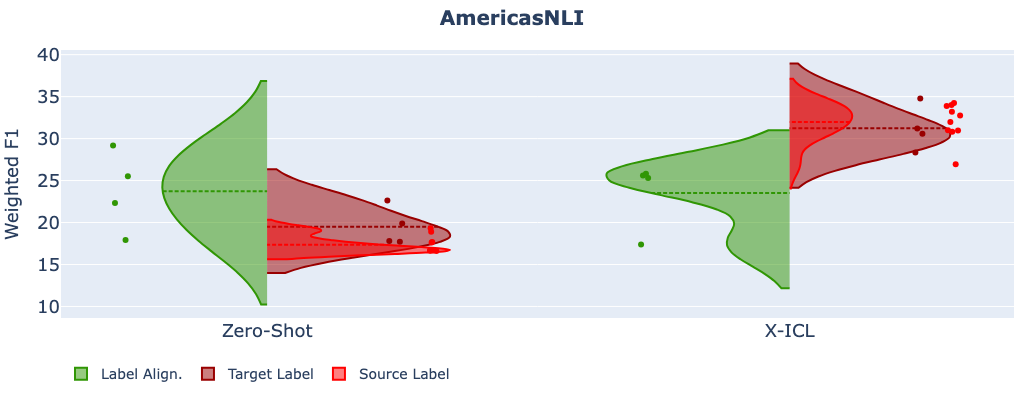

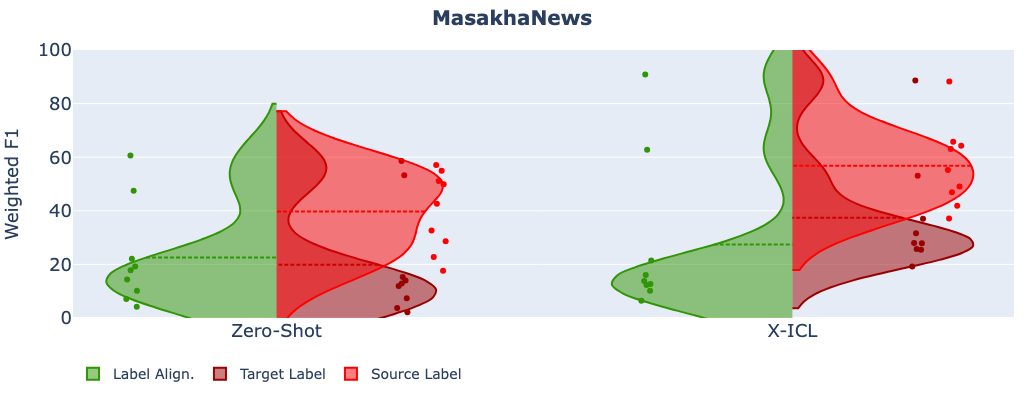

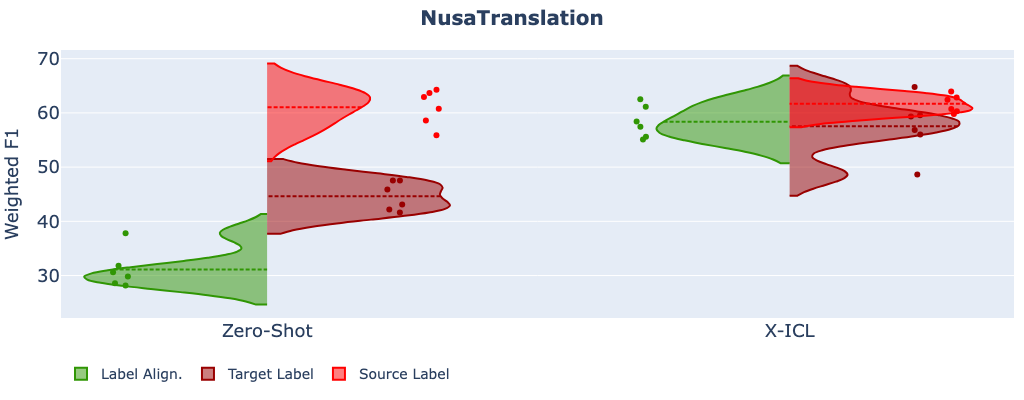

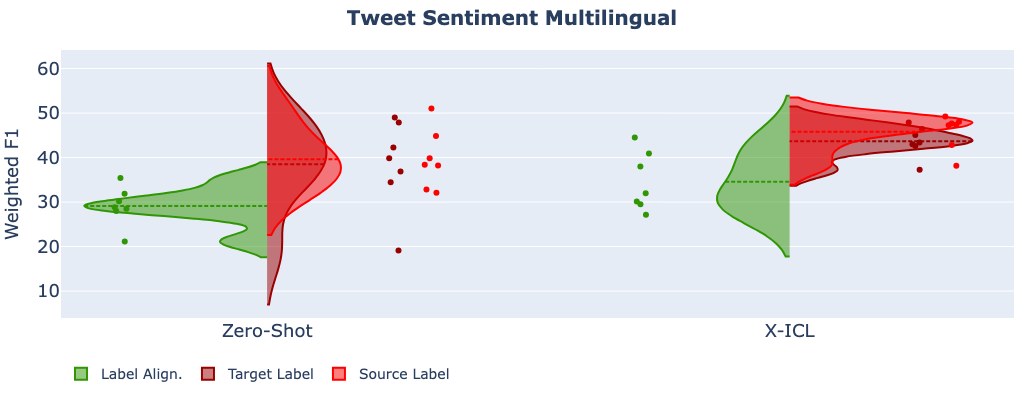

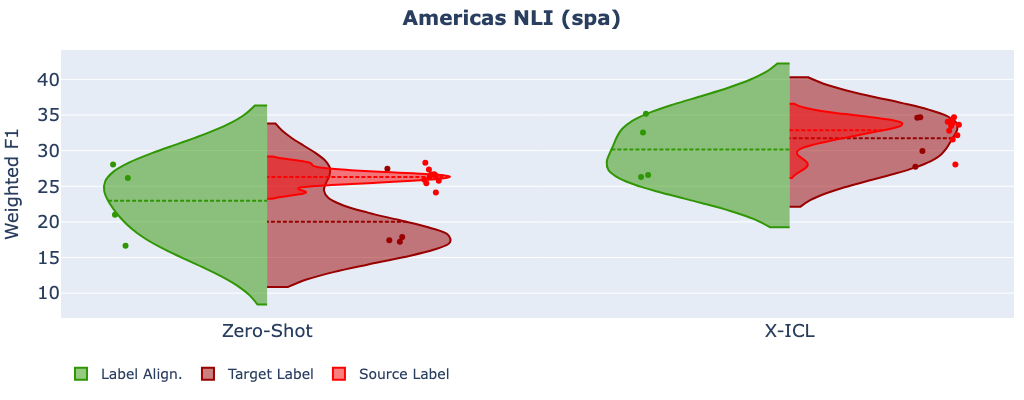

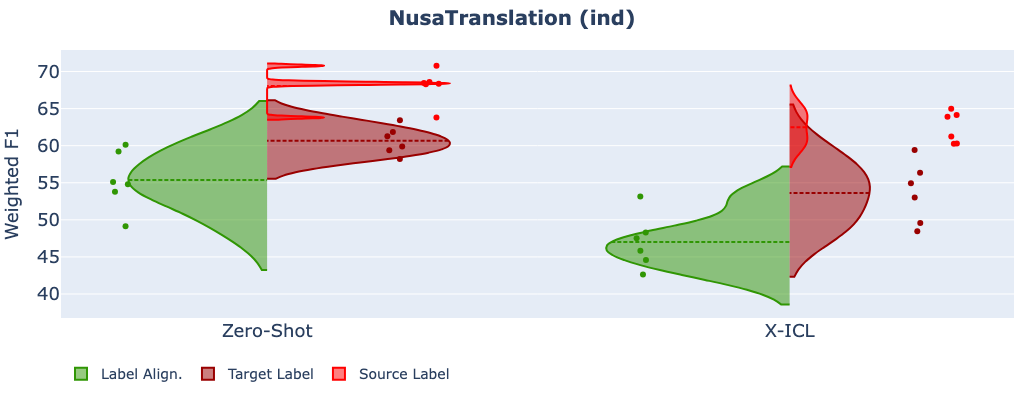

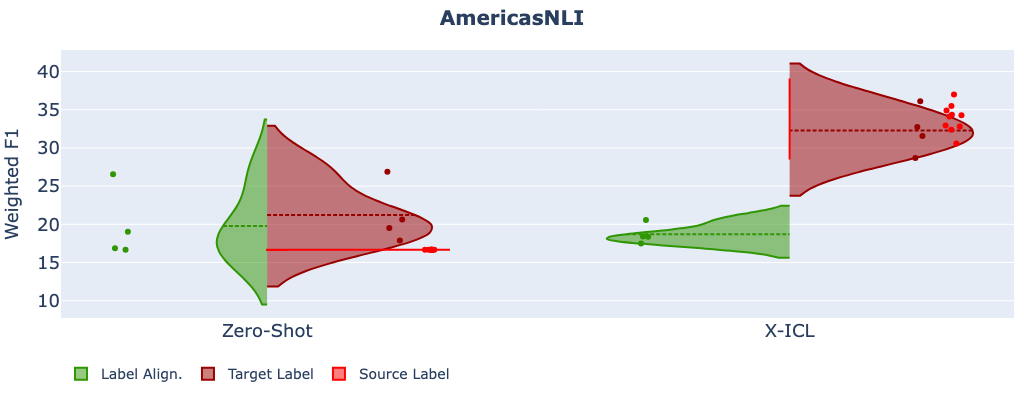

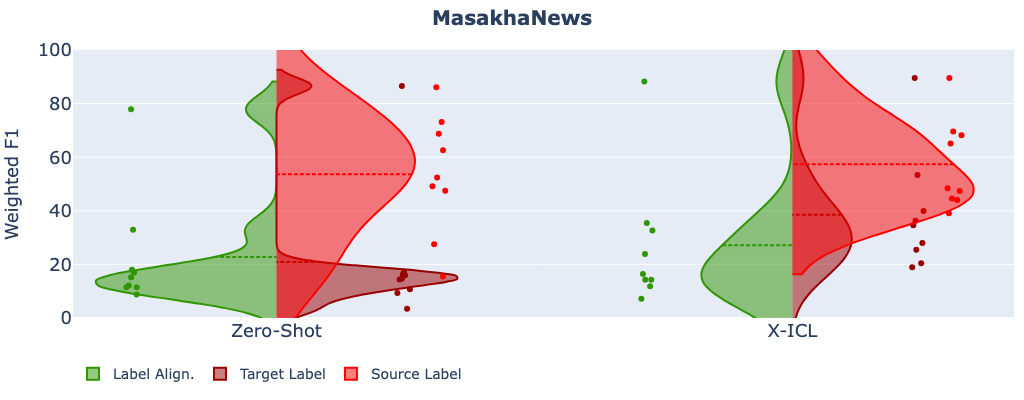

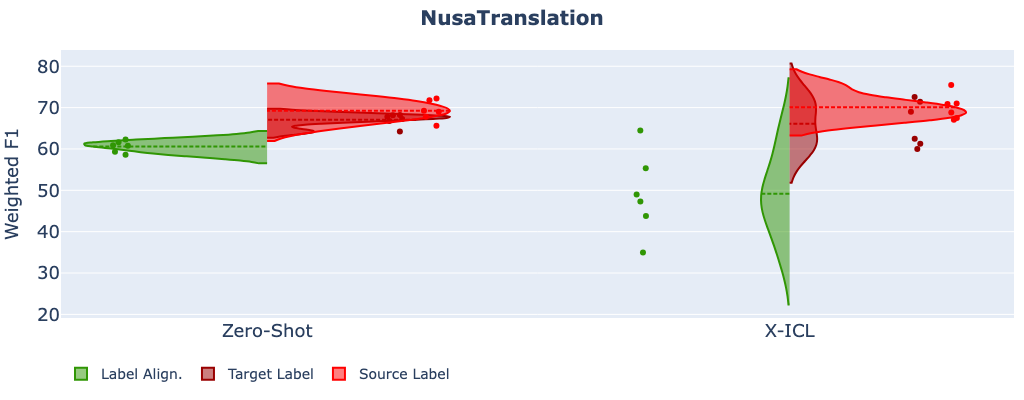

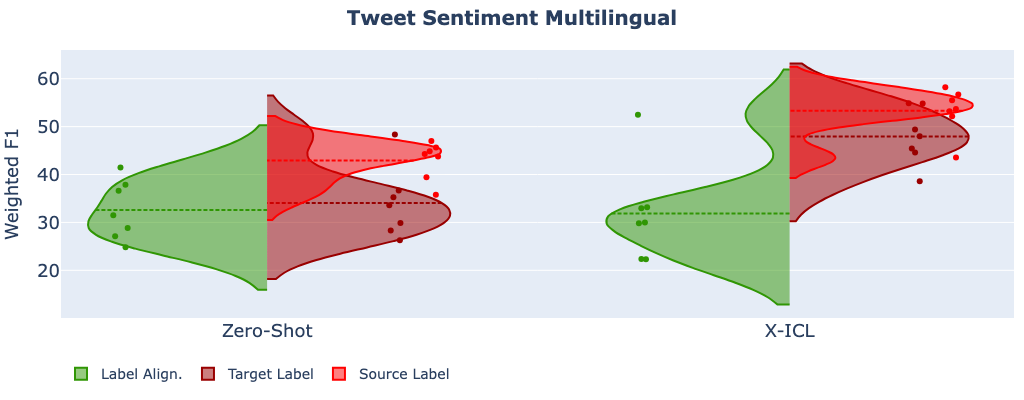

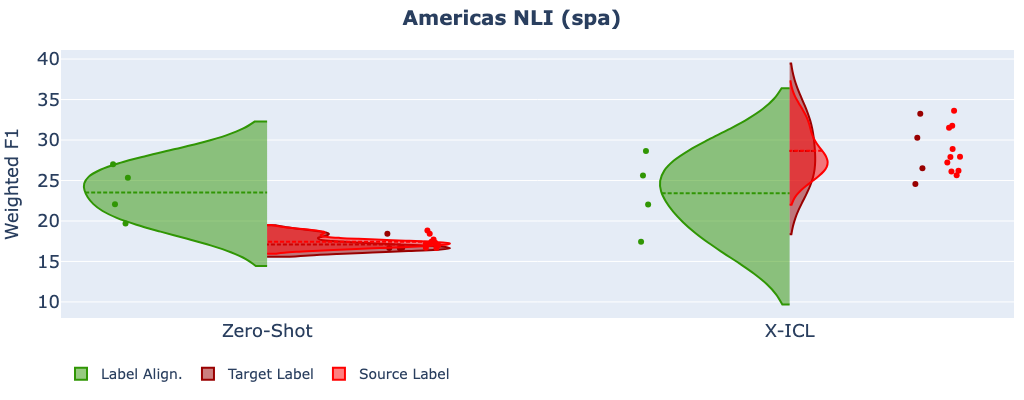

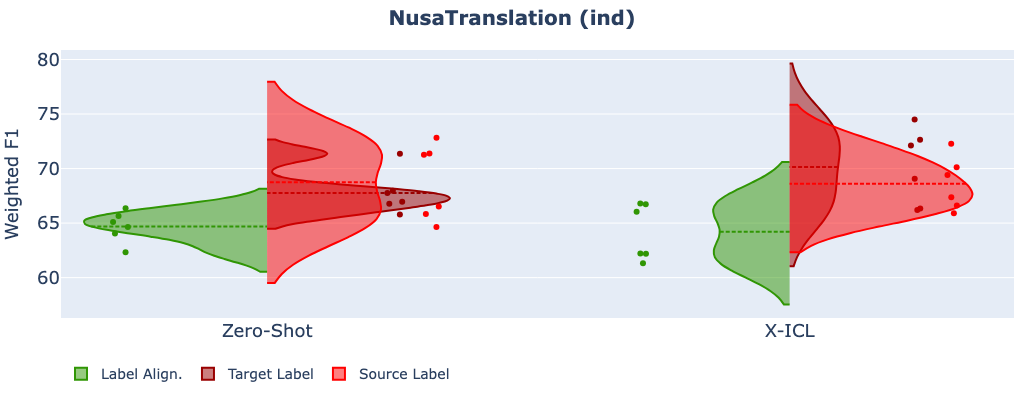

In [284]:
import plotly.graph_objects as go

import pandas as pd

for model_name in icl_df['model_name'].unique():
    for dataset in icl_df['dataset'].unique():
        pdf = icl_df.loc[
            (icl_df['dataset'] == dataset) & 
            (icl_df['model_name'] == model_name) & 
            (icl_df['icl_type'].isin(['cross', 'none'])) & (icl_df['iia_type'].isin(['none'])),:
        ]
        pdf['use_ioa'] = pdf['use_ioa'].map(label_map)
        pdf['model_type'] = pdf.apply(lambda x: ('Zero-Shot' if x['icl_type'] == 'none' else 'X-ICL'), axis='columns')
        pdf = pdf.sort_values(['use_ioa', 'icl_type', 'model_name'], ascending=False).reset_index(drop=True)

        fig = go.Figure()
        
        fig.add_trace(go.Violin(x=pdf['model_type'][ pdf['use_ioa'] == 'Label Alignment' ],
                                y=pdf['weighted_f1'][ pdf['use_ioa'] == 'Label Alignment' ],
                                legendgroup='Label Alignment', scalegroup='Label Alignment', name='Label Align.',
                                side='negative',
                                pointpos=-0.8,
                                # showlegend=False,
                                line_color='#309604')
                     )

        fig.add_trace(go.Violin(x=pdf['model_type'][ pdf['use_ioa'] == 'Target Label' ],
                                y=pdf['weighted_f1'][ pdf['use_ioa'] == 'Target Label' ],
                                legendgroup='Target Label', scalegroup='Target Label', name='Target Label',
                                side='positive',
                                pointpos=0.7,
                                # opacity=0.6,
                                # showlegend=False,
                                line_color='#990000')
                     )
        
        fig.add_trace(go.Violin(x=pdf['model_type'][ pdf['use_ioa'] == 'Source Label' ],
                                y=pdf['weighted_f1'][ pdf['use_ioa'] == 'Source Label' ],
                                legendgroup='Source Label', scalegroup='Source Label', name='Source Label',
                                side='positive',
                                pointpos=0.9,
                                # opacity=0.7,
                                # showlegend=False,
                                line_color='#ff0000')
                     )
        
        # fig.add_trace(go.Violin(x=df['day'][ df['smoker'] == 'Yes' ],
        #                         y=df['total_bill'][ df['smoker'] == 'Yes' ],
        #                         legendgroup='Yes', scalegroup='Yes', name='Yes',
        #                         side='negative',
        #                         line_color='blue')
        #              )
        # fig.add_trace(go.Violin(x=df['day'][ df['smoker'] == 'No' ],
        #                         y=df['total_bill'][ df['smoker'] == 'No' ],
        #                         legendgroup='No', scalegroup='No', name='No',
        #                         side='positive',
        #                         line_color='orange')
        #              )

        fig.update_yaxes(autorangeoptions=dict(clipmin=0, clipmax=100),
                        title_font=dict(size=18),
                         title_text="Weighted F1",
                        tickfont=dict(size=18))
        fig.update_xaxes(tickfont=dict(size=18))
        fig.update_traces(meanline_visible=True, points='all', # show all points
                          jitter=0.05,  # add some jitter on points for better visibility
                          # scalemode='count'
                         )
        fig.update_layout(violingap=0, violinmode='overlay',
                          autosize=True,
                            width=500,
                            height=400,
                            # xaxis=go.layout.XAxis(linecolor="black", linewidth=1, mirror=True),
                            # yaxis=go.layout.YAxis(linecolor="black", linewidth=1, mirror=True),
                            margin=go.layout.Margin(l=10, r=10, b=10, t=50, pad=0),
                          title_text=f'<b>{dataset_name_map[dataset]}</b>',
                          title_font=dict(size=20), title_x=0.5,
                          legend=dict(
                                orientation="h",
                                yanchor="top",
                                y=-0.15,
                                xanchor="left",
                                x=0,
                              font=dict(size=14),
                            ),
                         )
        fig.write_image(f"label_alignment/{dataset}_{model_name}.pdf", scale=10)
        fig.show()

#### More Specific Analysis (Per Language)

In [25]:
label_map = {'True': 'Label Alignment', 'False': 'Source Label', 'Target': 'Target Label'}

dfs = []
for model_name in icl_df['model_name'].unique():
    for dataset in icl_df['dataset'].unique():
        if dataset in ['americasnli-spa', 'nusatranslation-ind']:
            continue
            
        pdf = icl_df.loc[
            (icl_df['dataset'] == dataset) & 
            (icl_df['model_name'] == model_name) & 
            (icl_df['icl_type'].isin(['cross', 'none'])) & (icl_df['iia_type'].isin(['none'])),:
        ]
        # pdf['model_type'] = pdf.apply(lambda x: x['model_name'] + '\n' + ('Zero-Shot' if x['icl_type'] == 'none' else 'X-ICL'), axis='columns')
        pdf['model_type'] = pdf.apply(lambda x: ('Zero-Shot' if x['icl_type'] == 'none' else 'X-ICL'), axis='columns')
        pdf = pdf.sort_values(['use_ioa', 'icl_type', 'model_name'], ascending=False).reset_index(drop=True)
        
        f_df = pdf.loc[(pdf['use_ioa'] == 'False'),:].copy()
        t_df = pdf.loc[(pdf['use_ioa'] == 'True'),:].copy()

        f_df = f_df.set_index(['lang','model_type'])
        t_df = t_df.set_index(['lang','model_type'])

        t_df['weighted_f1'] = t_df['weighted_f1'] - f_df['weighted_f1']
        t_df['macro_f1'] = t_df['macro_f1'] - f_df['macro_f1']
        t_df['accuracy'] = t_df['accuracy'] - f_df['accuracy']
        
        dfs.append(t_df)

In [142]:
custom_colors = ['#ff0000', 'gold', '#32a400', 'violet', '#990000', 'darkorange', '#38761d', 'darkviolet']

dset_to_id = {
    'tweetsentimulti': 0, 
    'masakhanews': 1, 
    'nusatranslation': 2, 
    'americasnli': 3,
}

inf_type_to_id = {
    'Zero-Shot': 0,
    'X-ICL': 1
}

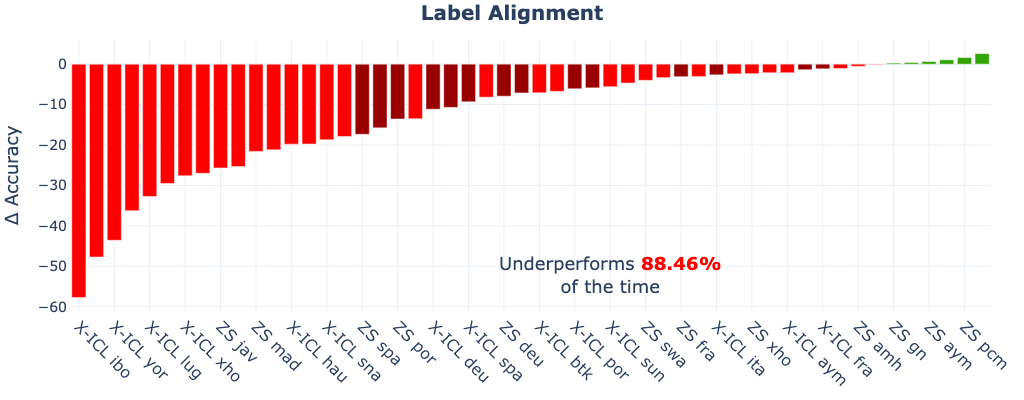

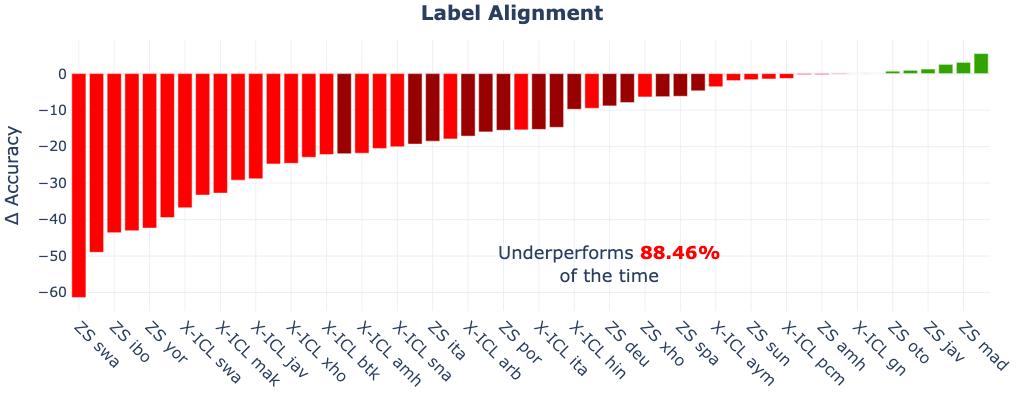

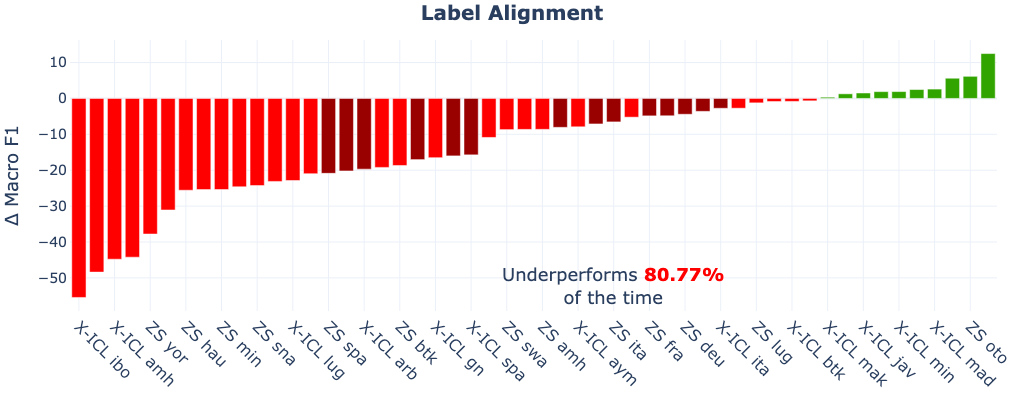

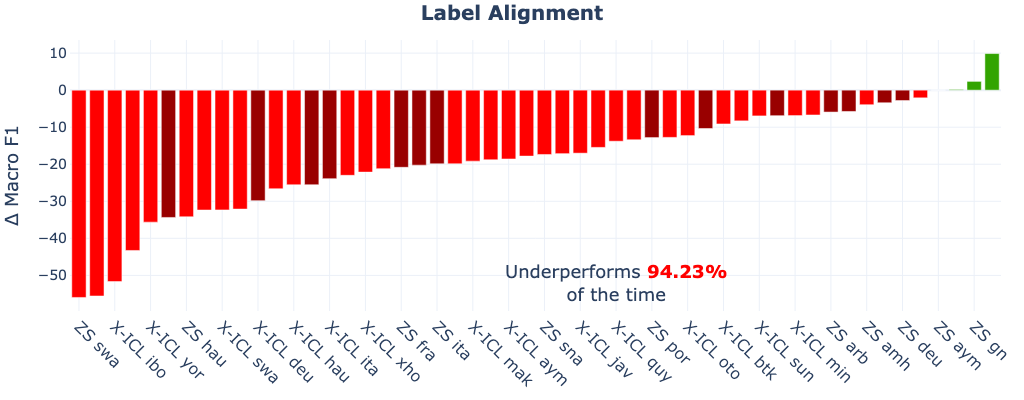

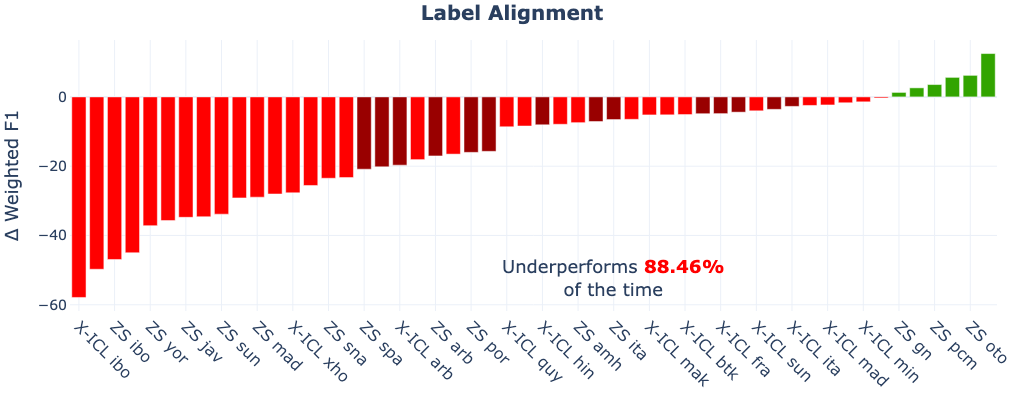

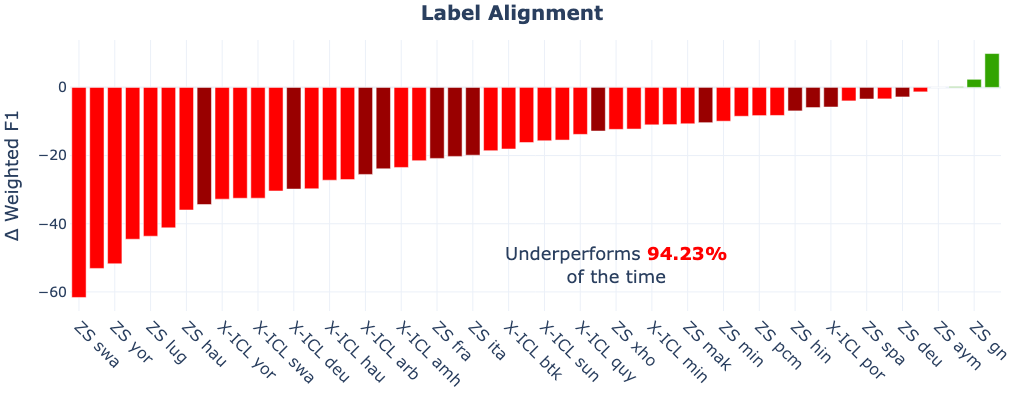

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

In [180]:
sdf = pd.concat(dfs).reset_index()
sdf['type'] = sdf.apply(lambda x: x['model_type'].replace('Zero-Shot', 'ZS') + '\n' + x['lang'], axis='columns')
# sdf['color'] = sdf.apply(
#     lambda x: custom_colors[(inf_type_to_id[x['model_type']] * len(dset_to_id)) + dset_to_id[x['dataset']]]
# , axis='columns')

for metric in ['accuracy','macro_f1','weighted_f1']:
    sdf['color'] = sdf.apply(
        lambda x: custom_colors[
            (0 if x[metric] <= 0 else 2) + (4 if x['dataset'] == 'tweetsentimulti' else 0)
        ]
    , axis='columns')
    for model_name in sdf['model_name'].unique():
        plt.figure(figsize=(8,4))
        pdf = sdf.loc[sdf['model_name'] == model_name].sort_values(metric).reset_index(drop=True)
        # pdf = pdf[pdf["model_type"] == "Zero-Shot"]
        fig = go.Figure()
        bar = go.Bar(x=pdf['type'], y=pdf[metric],
                        marker_color=pdf['color'],
                        # marker_pattern_shape=["/" if mt == "Zero-Shot" else "" for mt in pdf["model_type"].tolist()],
                        # marker_pattern_shape_sequence=[".", ""],
                     name="", showlegend=False,
                        )

        # ax.text(27, -55, f"Performance decrease\n{(pdf[metric] > 0).sum() / len(pdf) * 100:.2f}% of the time", color='blue', fontsize=18)
        # plt.title(model_name)

      #   #Custom Legend
      #   custom_legend = [
      #       go.Scatter(
      #           x=[None],
      #           y=[None],
      #           mode="markers",
      #           name="",
      #           marker=dict(size=7, color="green", symbol='square'),
      #       ),
      #       go.Scatter(
      #           x=[None],
      #           y=[None],
      #           mode="markers",
      #           name="LR lang",
      #           marker=dict(size=7, color="red", symbol='square'),
      #       ),

      #       go.Scatter(
      #           x=[None],
      #           y=[None],
      #           mode="markers",
      #           name="HR lang",
      #           marker=dict(size=7, color="#990000", symbol='square'),
      #       ),
      # ]

        fig = go.Figure(data=[bar])

        fig.add_annotation(x=30, y=-52,
            text=f"Underperforms <b style='color:red';>{100 - (pdf[metric] > 0).sum() / len(pdf) * 100:.2f}%</b><br>of the time",
            showarrow=False, font=dict(size=18),
            yshift=0)

        fig.update_yaxes(title_font=dict(size=18),
                         title_text='Δ ' + ' '.join(map(lambda x: x.capitalize(), metric.split('_'))),
                        tickfont=dict(size=14))

        fig.update_xaxes(tickfont=dict(size=16), tickangle=45, showgrid=True)

        fig.update_layout(violingap=0, violinmode='overlay',
                          autosize=True,
                            width=400,
                            height=400,
                            # xaxis=go.layout.XAxis(linecolor="black", linewidth=1, mirror=True),
                            # yaxis=go.layout.YAxis(linecolor="black", linewidth=1, mirror=True),
                            margin=go.layout.Margin(l=10, r=10, b=10, t=40, pad=2),
                          title_text=f'<b>Label Alignment</b>',
                          title_font=dict(size=20), title_x=0.5,
                          legend=dict(
                                orientation="h",
                                yanchor="bottom",
                                y=-0.2,
                                xanchor="right",
                                x=0.5,
                              # visible=True,
                            ),
                          template='plotly_white',
                         )
        fig.write_image(f'label_alignment_detail/{model_name}_{metric}.pdf', scale=10)
        fig.show()

### \paragraph{Input Alignment}
##### % Boxen chart IIA True/False for ZS and X-ICL on Higher resource languages & underrepresented languages (per regions)

In [181]:
dfs = []
for path in glob.glob('../metrics/*.csv'):
    meta = path.split('/')[-1][:-4].split('_')
    dset_name, model_name = meta[1], meta[2]
    
    icl_meta = meta[3][4:]
    num_icl = int(icl_meta[-1])
    icl_type = icl_meta.split('-')[0]
    icl_idx = icl_meta[len(icl_type)+1:-2]
        
    iia_meta = meta[4][4:]
    num_iia = int(iia_meta[-1])
    iia_type = iia_meta.split('-')[0]
    iia_idx = iia_meta[len(iia_type)+1:-2]
    
    use_ioa = meta[5].split('-')[1]
    
    # print(f'{dset_name} {model_name} {use_ioa}')
    # print(f'{icl_type} {num_icl} {icl_idx}')
    # print(f'{iia_type} {num_iia} {iia_idx}')
    
    # Load Metrics
    df = pd.read_csv(path)
    df = df.T
    df.columns = df.head(1).values[0]
    df = df.iloc[1:]

    # Inject Metadata
    df['model_name'] = model_name
    df['num_icl'] = num_icl
    df['icl_type'] = icl_type
    df['icl_idx'] = icl_idx
    df['num_iia'] = num_iia
    df['iia_type'] = iia_type
    df['iia_idx'] = iia_idx
    df['use_ioa'] = use_ioa
    
    df['accuracy'] = pd.to_numeric(df['accuracy']) * 100
    df['macro_f1'] = pd.to_numeric(df['macro_f1']) * 100
    df['weighted_f1'] = pd.to_numeric(df['weighted_f1']) * 100
    
    # Change Dataset Experiments
    df['dataset'] = df['dataset'].apply(lambda x: 'tweetsentimulti' if x == 'tweet_senti_multi' else x)
    
    # Remove Unused Experiments
    df = df.loc[(df['icl_type'] != 'cross') | (~df['icl_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['iia_type'] != 'cross') | (~df['iia_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['lang'] != 'eng'),:]
    dfs.append(df)
    
icl_df = pd.concat(dfs)

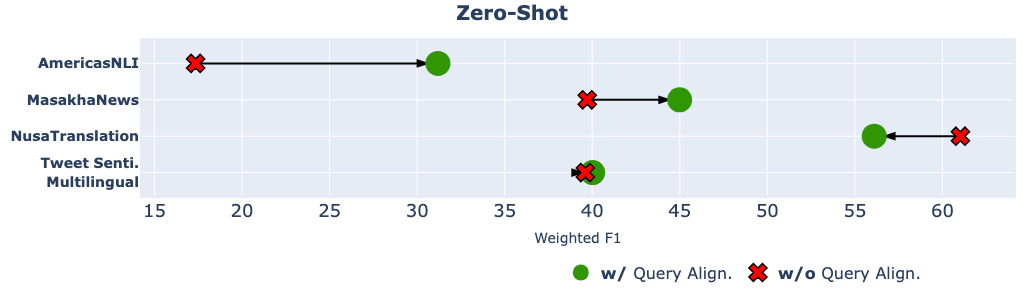

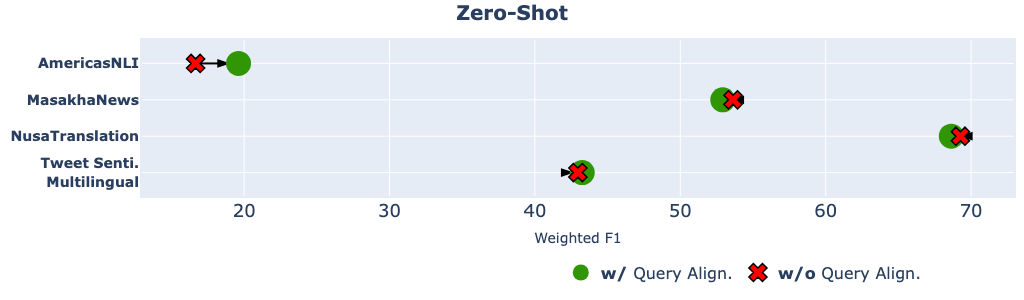

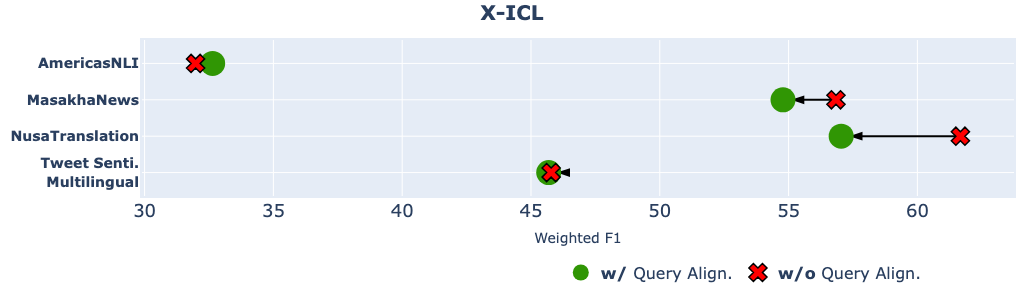

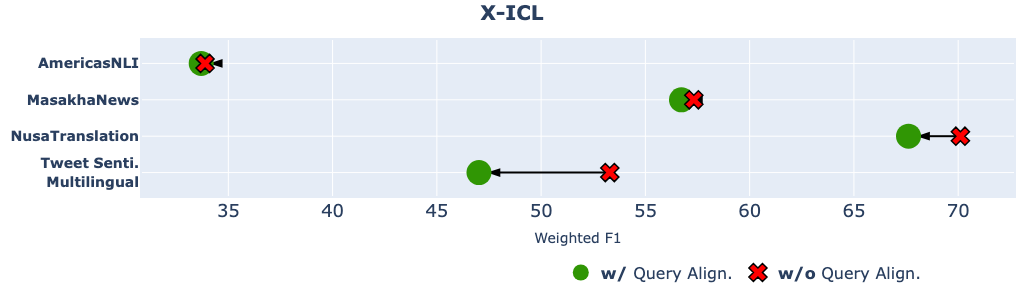

In [182]:
import pandas as pd
import plotly.graph_objects as go
from plotly import data

label_map = {'none': 'w/o Query Alignment', 'mono': 'w/ Query Alignment'}

dataset_map = {"americasnli": "<b>AmericasNLI<b>", "nusatranslation": "<b>NusaTranslation</b>", "masakhanews": "<b>MasakhaNews</b>",
              "tweetsentimulti": "<b>Tweet Senti.<br>Multilingual</b>", "americasnli-spa": "Americas NLI (spa)", "nusatranslation-ind": "NusaTranslation (ind)"}

mdf = icl_df.loc[
    (
        ((icl_df['iia_type'] == 'mono') & (icl_df['iia_idx'].isin(['sbert']))) | 
        (icl_df['iia_type'] == 'none')
    ) & (icl_df['icl_type'].isin(['cross', 'none'])) & (icl_df['icl_idx'].isin(['sbert', 'random'])) & (icl_df['use_ioa'].isin(['False']))
,:]
mdf['model_type'] = mdf.apply(lambda x: ('Zero-Shot' if x['icl_type'] == 'none' else 'X-ICL'), axis='columns')
mdf['iia_type'] = mdf['iia_type'].map(label_map)
mdf['dataset'] = mdf['dataset'].map(dataset_map)

mean_mdf = mdf.groupby(['model_type', 'dataset', 'model_name', 'iia_type'])['weighted_f1'].mean().to_frame()
mean_mdf = mean_mdf.reset_index()
mean_mdf = mean_mdf[(mean_mdf['dataset'] != 'Americas NLI (spa)') & (mean_mdf['dataset'] != 'NusaTranslation (ind)')]


for model_type in mdf['model_type'].unique():
    for model_name in mdf['model_name'].unique():
        pdf = mean_mdf[(mean_mdf["model_type"] == model_type) & (mean_mdf["model_name"] == model_name)]
        pdf = pdf.sort_values(['dataset', 'iia_type'], ascending=False).reset_index(drop=True)
        
        with_none_x, with_none_y = [], []
        for i in range(len(pdf)):
            if i > 0 and i % 2 == 0:
                with_none_x.append(None)
                with_none_y.append(None)
            with_none_x.append(pdf['weighted_f1'][i])
            with_none_y.append(pdf['dataset'][i])
        
        fig = go.Figure(
            data=[
                go.Scatter(
                    x=with_none_x,
                    y=with_none_y,
                    mode="markers+lines",
                    showlegend=False,
                    marker=dict(
                        symbol="arrow", 
                        color="black", 
                        size=14, 
                        angleref="previous", 
                        standoff=8
                    )
                ),
                go.Scatter(
                    x=pdf[pdf['iia_type'] == 'w/ Query Alignment']['weighted_f1'],
                    y=pdf[pdf['iia_type'] == 'w/o Query Alignment']['dataset'],
                    name='<b>w/</b> Query Align.',
                    mode="markers",
                    marker=dict(
                        color="#309604",
                        size=25,
                        symbol="circle",
                    ),
                ),
                go.Scatter(
                    x=pdf[pdf['iia_type'] == 'w/o Query Alignment']['weighted_f1'],
                    y=pdf[pdf['iia_type'] == 'w/o Query Alignment']['dataset'], 
                    name='<b>w/o</b> Query Align.',
                    mode="markers",
                    marker=dict(
                        color="red",
                        size=16,
                        symbol="x",
                        line_width=1.5,
                        line_color="black",
                    )
                ),
            ]
        )
        
        fig.update_yaxes(tickfont=dict(size=14))
        fig.update_xaxes(tickfont=dict(size=18), title_text="Weighted F1", title_font=dict(size=14))
        fig.update_layout(
                          autosize=True,
                            width=600,
                            height=300,
                            margin=go.layout.Margin(l=10, r=10, b=60, t=40, pad=2),
                          title_text=f'<b>{model_type}</b>',
                          title_font=dict(size=20), title_x=0.5,
                          legend=dict(
                                orientation="h",
                                yanchor="bottom",
                                y=-0.6,
                                xanchor="right",
                                x=0.9,
                              font=dict(size=16),
                            ),
                         )
        
        fig.write_image(f"input_alignment/{model_type}_{model_name}.pdf", scale=10)
        fig.show()

#### More Specific Analysis (Per Language)

In [190]:
label_map = {'none': 'w/o Input Alignment', 'mono': 'w/ Input Alignment'}

mdf = icl_df.loc[
    (
        ((icl_df['iia_type'] == 'mono') & (icl_df['iia_idx'].isin(['sbert']))) | 
        (icl_df['iia_type'] == 'none')
    ) & (icl_df['icl_type'].isin(['cross', 'none'])) & (icl_df['icl_idx'].isin(['sbert', 'random'])) & (icl_df['use_ioa'].isin(['False']))
,:]
mdf['model_type'] = mdf.apply(lambda x: ('Zero-Shot' if x['icl_type'] == 'none' else 'X-ICL'), axis='columns')

dfs = []
for model_name in mdf['model_name'].unique():
    for dataset in mdf['dataset'].unique():
        if dataset in ['americasnli-spa', 'nusatranslation-ind']:
            continue
            
        pdf = mdf.loc[(mdf['dataset'] == dataset) & (mdf['model_name'] == model_name),:]
        pdf = pdf.sort_values(['iia_type', 'icl_type', 'model_name'], ascending=False).reset_index(drop=True)
        pdf['iia_type'] = pdf['iia_type'].apply(lambda x: label_map[x])
        
        f_df = pdf.loc[(pdf['iia_type'] == 'w/o Input Alignment'),:].copy()
        t_df = pdf.loc[(pdf['iia_type'] == 'w/ Input Alignment'),:].copy()

        f_df = f_df.set_index(['lang','model_type'])
        t_df = t_df.set_index(['lang','model_type'])

        t_df['weighted_f1'] = t_df['weighted_f1'] - f_df['weighted_f1']
        t_df['macro_f1'] = t_df['macro_f1'] - f_df['macro_f1']
        t_df['accuracy'] = t_df['accuracy'] - f_df['accuracy']
        
        dfs.append(t_df)
sdf = pd.concat(dfs).reset_index()

In [191]:
custom_colors = ['#ff0000', 'gold', '#32a400', 'violet', '#990000', 'darkorange', '#38761d', 'darkviolet']

dset_to_id = {
    'tweetsentimulti': 0, 
    'masakhanews': 1, 
    'nusatranslation': 2, 
    'americasnli': 3,
}

inf_type_to_id = {
    'Zero-Shot': 0,
    'X-ICL': 1
}

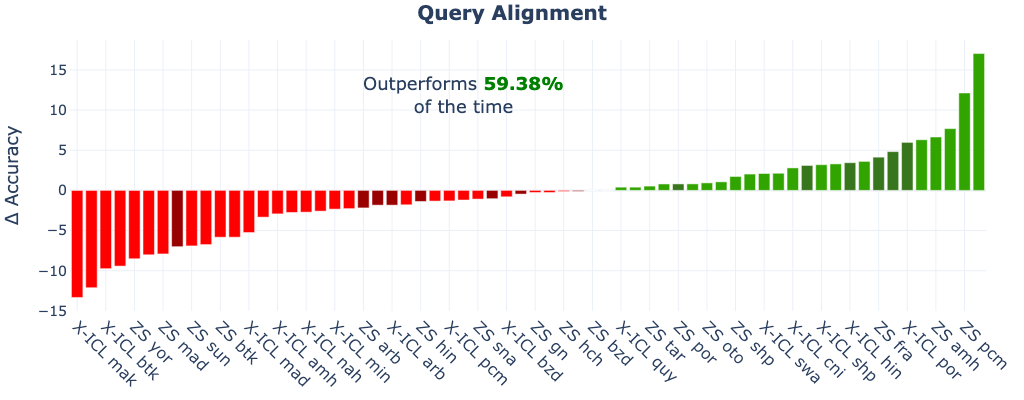

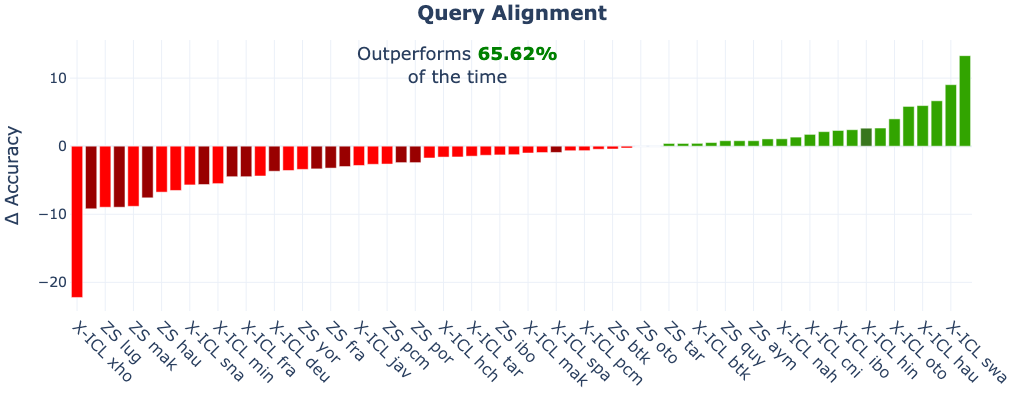

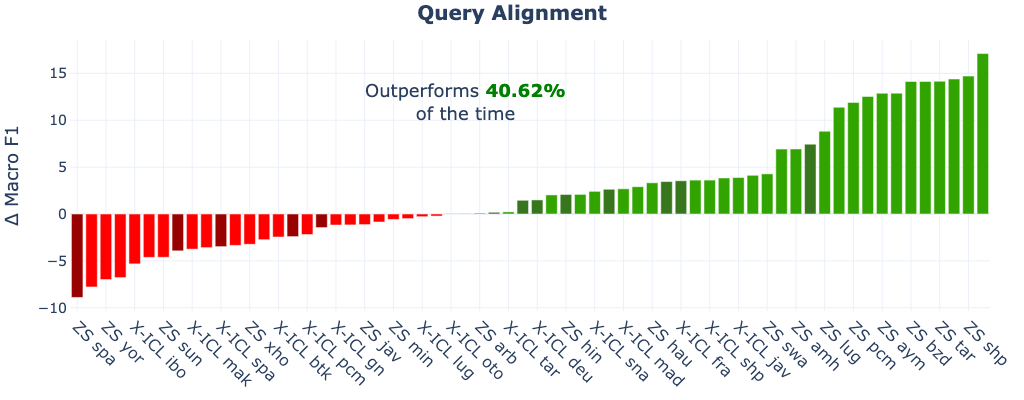

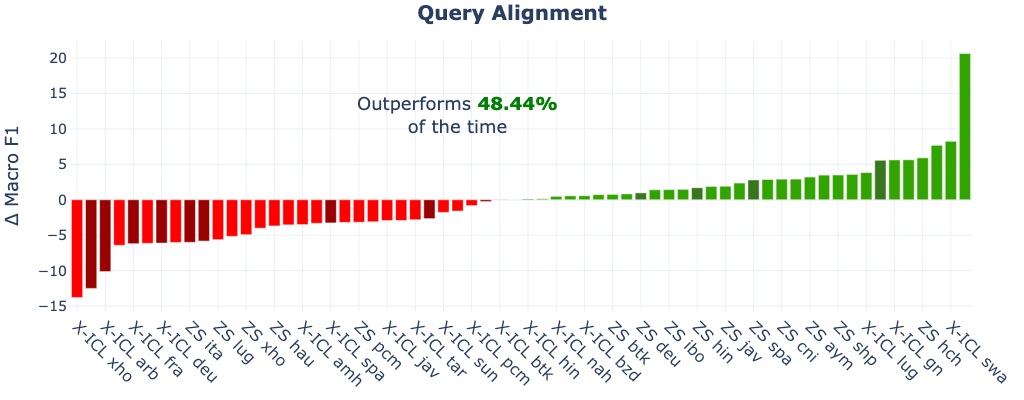

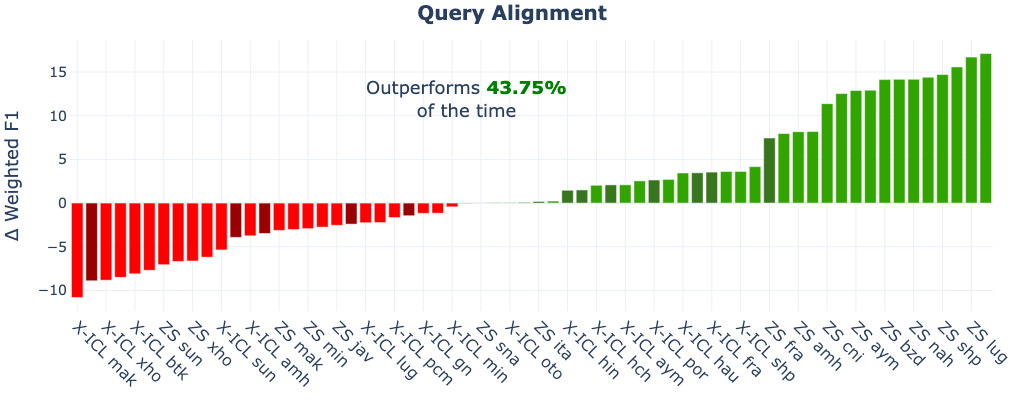

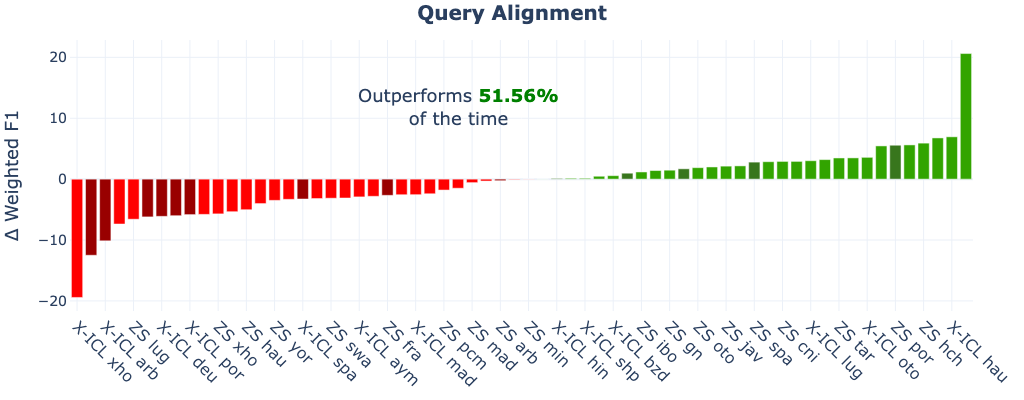

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

In [208]:
sdf = pd.concat(dfs).reset_index()
sdf['type'] = sdf.apply(lambda x: x['model_type'].replace('Zero-Shot', 'ZS') + '\n' + x['lang'], axis='columns')
# sdf['color'] = sdf.apply(
#     lambda x: custom_colors[(inf_type_to_id[x['model_type']] * len(dset_to_id)) + dset_to_id[x['dataset']]]
# , axis='columns')

for metric in ['accuracy','macro_f1','weighted_f1']:
    sdf['color'] = sdf.apply(
        lambda x: custom_colors[
            (0 if x[metric] <= 0 else 2) + (4 if x['dataset'] == 'tweetsentimulti' else 0)
        ]
    , axis='columns')
    for model_name in sdf['model_name'].unique():
        plt.figure(figsize=(8,4))
        pdf = sdf.loc[sdf['model_name'] == model_name].sort_values(metric).reset_index(drop=True)
        # pdf = pdf[pdf["model_type"] == "Zero-Shot"]
        fig = go.Figure()
        bar = go.Bar(x=pdf['type'], y=pdf[metric],
                        marker_color=pdf['color'],
                        # marker_pattern_shape=["/" if mt == "Zero-Shot" else "" for mt in pdf["model_type"].tolist()],
                        # marker_pattern_shape_sequence=[".", ""],
                     name="", showlegend=False,
                        )
        fig = go.Figure(data=[bar])

        fig.add_annotation(x=27, y=12,
            text=f"Outperforms <b style='color:green';>{100 - (pdf[metric] > 0).sum() / len(pdf) * 100:.2f}%</b><br>of the time",
            showarrow=False, font=dict(size=18),
            yshift=0)

        fig.update_yaxes(title_font=dict(size=18),
                         title_text='Δ ' + ' '.join(map(lambda x: x.capitalize(), metric.split('_'))),
                        tickfont=dict(size=14))

        fig.update_xaxes(tickfont=dict(size=16), tickangle=45, showgrid=True)

        fig.update_layout(violingap=0, violinmode='overlay',
                          autosize=True,
                            width=400,
                            height=400,
                            # xaxis=go.layout.XAxis(linecolor="black", linewidth=1, mirror=True),
                            # yaxis=go.layout.YAxis(linecolor="black", linewidth=1, mirror=True),
                            margin=go.layout.Margin(l=10, r=10, b=10, t=40, pad=2),
                          title_text=f'<b>Query Alignment</b>',
                          title_font=dict(size=20), title_x=0.5,
                          legend=dict(
                                orientation="h",
                                yanchor="bottom",
                                y=-0.2,
                                xanchor="right",
                                x=0.5,
                              # visible=True,
                            ),
                          template='plotly_white',
                         )
        fig.write_image(f'input_alignment_detail/{model_name}_{metric}.pdf', scale=10)
        fig.show()

### \subsection{Marginal Effect of Format Consistency}
##### IIA Alignment Before, IIA Alignment After, ITC on X-ICL on Higher resource languages & underrepresented languages (per regions)


In [ ]:
dfs = []
for path in glob.glob('../metrics_icl/*.csv'):
    meta = path.split('/')[-1][:-4].split('_')
    dset_name, model_name = meta[1], meta[2]
    
    icl_meta = meta[3][4:]
    num_icl = int(icl_meta[-1])
    icl_type = icl_meta.split('-')[0]
    icl_idx = icl_meta[len(icl_type)+1:-2]
        
    iia_meta = meta[4][4:]
    num_iia = int(iia_meta[-1])
    iia_type = iia_meta.split('-')[0]
    iia_idx = iia_meta[len(iia_type)+1:-2]
    
    use_ioa = meta[5].split('-')[1]
    align_pos = meta[6].split('-')[1]
    
    # print(f'{dset_name} {model_name} {use_ioa}')
    # print(f'{icl_type} {num_icl} {icl_idx}')
    # print(f'{iia_type} {num_iia} {iia_idx}')
    
    # Load Metrics
    df = pd.read_csv(path)
    df = df.T
    df.columns = df.head(1).values[0]
    df = df.iloc[1:]

    # Inject Metadata
    df['model_name'] = model_name
    df['num_icl'] = num_icl
    df['icl_type'] = icl_type
    df['icl_idx'] = icl_idx
    df['num_iia'] = num_iia
    df['iia_type'] = iia_type
    df['iia_idx'] = iia_idx
    df['use_ioa'] = use_ioa
    df['align_pos'] = align_pos
    
    df['accuracy'] = pd.to_numeric(df['accuracy']) * 100
    df['macro_f1'] = pd.to_numeric(df['macro_f1']) * 100
    df['weighted_f1'] = pd.to_numeric(df['weighted_f1']) * 100
    
    # Change Dataset Experiments
    df['dataset'] = df['dataset'].apply(lambda x: 'tweetsentimulti' if x == 'tweet_senti_multi' else x)
    
    # Remove Unused Experiments
    df = df.loc[(df['icl_type'] != 'cross') | (~df['icl_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['iia_type'] != 'cross') | (~df['iia_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['lang'] != 'eng'),:]
    dfs.append(df)
    
icl_df = pd.concat(dfs)

In [ ]:
dfs = []
for path in glob.glob('../metrics_itc/*.csv'):
    meta = path.split('/')[-1][:-4].split('_')
    dset_name, model_name = meta[1], meta[2]
    
    meta[3] = meta[3].replace('mono-tran', 'monotrans')
    itc_meta = meta[3][4:].split('-')
    itc_num = int(itc_meta[2])
    itc_label = itc_meta[-1]
    itc_type, itc_idx = itc_meta[:2]
    
    # Load Metrics
    df = pd.read_csv(path)
    df = df.T
    df.columns = df.head(1).values[0]
    df = df.iloc[1:]

    # Inject Metadata
    df['model_name'] = model_name
    df['itc_num'] = itc_num
    df['itc_label'] = itc_label
    df['itc_type'] = itc_type
    df['itc_idx'] = itc_idx
    
    df['accuracy'] = pd.to_numeric(df['accuracy']) * 100
    df['macro_f1'] = pd.to_numeric(df['macro_f1']) * 100
    df['weighted_f1'] = pd.to_numeric(df['weighted_f1']) * 100
    
    # Remove Unused Experiments
    df['itc_type'] = df['itc_type'].apply(lambda x: 'monotrans' if x == 'monotranss' else x)
    dfs.append(df)
    
itc_df = pd.concat(dfs)

In [ ]:
label_map = {'itc': 'tabular', 'after': 'alignment-after', 'before': 'alignment-first'}

itc_df['align_pos'] = 'itc'
mdf = pd.concat([
    icl_df.loc[
        (icl_df['icl_type'].isin(['cross'])) & (icl_df['iia_type'].isin(['mono']) & 
        (icl_df['use_ioa'].isin(['False']))) & (icl_df['iia_idx'].isin(['unique$tf-idf$sbert'])),
        ['dataset', 'lang', 'weighted_f1', 'icl_type', 'align_pos', 'model_name']
    ],
    itc_df.loc[
        (itc_df['itc_label'] == 'Source') & (itc_df['itc_type'].isin(['cross'])) & (itc_df['itc_idx'].isin(['sbert'])), 
       ['dataset', 'lang', 'weighted_f1', 'itc_type', 'align_pos', 'model_name']
    ].rename({'itc_type': 'icl_type'}, axis='columns')

])
mdf['model_type'] = mdf.apply(lambda x: x['model_name'] + '\n' + ('Zero-Shot' if x['icl_type'] == 'none' else 'X-ICL'), axis='columns')

for model_name in mdf['model_name'].unique():
    for dataset in mdf['dataset'].unique():
        pdf = mdf.loc[
            (mdf['model_name'] == model_name) &
            (mdf['dataset'] == dataset),:
        ].sort_values(['icl_type','model_name'], ascending=False)

        ax = sns.boxenplot(x = "model_type",
                    y = "weighted_f1",
                    hue = "align_pos",
                    data = pdf,
                    k_depth=7, dodge=True)
        sns.stripplot(x = "model_type",
                      y = "weighted_f1", 
                      hue = "align_pos",
                      color = "black",
                      size = 5,
                      alpha = 0.5,
                      data = pdf, 
                      dodge=True, ax=ax)

        h, l = ax.get_legend_handles_labels()
        ax.legend(handles=[item for item in h[:3]], labels=[label_map[item] for item in l[:3]], fontsize=17)
        plt.ylabel('Weighted F1',fontsize=18)
        plt.xlabel('')
        plt.xticks(fontsize=17)
        plt.yticks(fontsize=17)
        plt.title(f'{dataset_name_map[dataset]} | {model_name}', fontsize=18)
        plt.locator_params(axis='y', nbins=5)
        plt.savefig(f'format_consistency/{dataset}_{model_name}.pdf', bbox_inches='tight')
        plt.show()


### \paragraph{Cross-Lingual, Monolingual, and Translation Semantic Similarity}
##### Different X-ICL & XPresso w/ IOA/IIA/IOA+IIA on Higher resource languages & underrepresented languages (per regions)

In [ ]:
dfs = []
for path in glob.glob('../metrics_icl/*.csv'):
    meta = path.split('/')[-1][:-4].split('_')
    dset_name, model_name = meta[1], meta[2]
    
    icl_meta = meta[3][4:]
    num_icl = int(icl_meta[-1])
    icl_type = icl_meta.split('-')[0]
    icl_idx = icl_meta[len(icl_type)+1:-2]
        
    iia_meta = meta[4][4:]
    num_iia = int(iia_meta[-1])
    iia_type = iia_meta.split('-')[0]
    iia_idx = iia_meta[len(iia_type)+1:-2]
    
    use_ioa = meta[5].split('-')[1]
    align_pos = meta[6].split('-')[1]
    
    # print(f'{dset_name} {model_name} {use_ioa}')
    # print(f'{icl_type} {num_icl} {icl_idx}')
    # print(f'{iia_type} {num_iia} {iia_idx}')
    
    # Load Metrics
    df = pd.read_csv(path)
    df = df.T
    df.columns = df.head(1).values[0]
    df = df.iloc[1:]

    # Inject Metadata
    df['model_name'] = model_name
    df['num_icl'] = num_icl
    df['icl_type'] = icl_type
    df['icl_idx'] = icl_idx
    df['num_iia'] = num_iia
    df['iia_type'] = iia_type
    df['iia_idx'] = iia_idx
    df['use_ioa'] = use_ioa
    df['align_pos'] = align_pos
    
    df['accuracy'] = pd.to_numeric(df['accuracy']) * 100
    df['macro_f1'] = pd.to_numeric(df['macro_f1']) * 100
    df['weighted_f1'] = pd.to_numeric(df['weighted_f1']) * 100
    
    # Change Dataset Experiments
    df['dataset'] = df['dataset'].apply(lambda x: 'tweetsentimulti' if x == 'tweet_senti_multi' else x)
    
    # Remove Unused Experiments
    df = df.loc[(df['icl_type'] != 'cross') | (~df['icl_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['iia_type'] != 'cross') | (~df['iia_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['lang'] != 'eng'),:]
    dfs.append(df)
    
icl_df = pd.concat(dfs)

In [ ]:
icl_map = {'mono': 'ICL', 'cross': 'X-ICL', 'xpresso': 'T-ICL'}
icl_idx_map = {'random': 'Random', 'sbert': 'SBERT','unique$tf-idf$sbert': 'SBERT+'}
icl_group_id = {'Zero-Shot': 0, 'ICL Random': 1, 'ICL SBERT': 2, 'X-ICL SBERT': 3, 'T-ICL SBERT+': 4}
for model_name in icl_df['model_name'].unique():
    for dataset in icl_df['dataset'].unique():
        pdf = pd.concat([
            # old_icl_df.loc[
            #     (old_icl_df['icl_type'] == 'mono') & (old_icl_df['icl_idx'] == 'random') & 
            #     (old_icl_df['iia_type'] == 'none') & (old_icl_df['use_ioa'] == 'False'), 
            #     ['dataset', 'lang', 'accuracy', 'macro_f1', 'weighted_f1', 'model_name', 'num_icl', 'icl_type', 'icl_idx']
            # ],
            icl_df.loc[
                # (icl_df['model_name'] == model_name) & 
                (icl_df['dataset'] == dataset) & 
                (
                    (
                        (icl_df['icl_type'].isin(['xpresso'])) &
                        (icl_df['icl_idx'].isin(['unique$tf-idf$sbert']))
                    ) |
                    (
                        (icl_df['icl_type'].isin(['none'])) &
                        (icl_df['icl_idx'].isin(['random']))
                    ) |
                    (
                        (icl_df['icl_type'].isin(['cross', 'mono'])) &
                        (icl_df['icl_idx'].isin(['sbert'])) 
                    )
                ) & (icl_df['use_ioa'].isin(['False'])) & (icl_df['iia_type'].isin(['none'])),
                ['dataset', 'lang', 'accuracy', 'macro_f1', 'weighted_f1', 'model_name', 'num_icl', 'icl_type', 'icl_idx']
            ]
        ])

        pdf['icl_group'] = pdf.apply(lambda x: icl_map[x['icl_type']] + ' ' +  icl_idx_map[x['icl_idx']] if x['icl_type'] != 'none' else 'Zero-Shot', axis='columns')
        pdf['icl_id'] = pdf['icl_group'].apply(lambda x: icl_group_id[x])
        pdf = pdf.sort_values(['model_name', 'icl_id'], ascending=[False, True]).reset_index(drop=True)

        ax = sns.boxenplot(x = "model_name",
                    y = "weighted_f1",
                    hue = "icl_group",
                    data = pdf,
                    k_depth=7, dodge=True)
        sns.stripplot(x = "model_name",
                      y = "weighted_f1", 
                      hue = "icl_group",
                      color = "black",
                      size = 5,
                      alpha = 0.5,
                      data = pdf, 
                      dodge=True, ax=ax)

        h, l = ax.get_legend_handles_labels()
        ax.legend(handles=[item for item in h[:4]], labels=[item for item in l[:4]], fontsize=17)
        plt.ylabel('Weighted F1',fontsize=18)
        plt.xlabel('')
        plt.xticks([], [])
        plt.yticks(fontsize=17)
        plt.title(f'{dataset_name_map[dataset]} | {model_name}', fontsize=18)
        plt.locator_params(axis='y', nbins=4)
        # plt.savefig(f'semantic_similarity/{dataset}_{model_name}.pdf', bbox_inches='tight')
        plt.show()


### \paragraph{Semantic Similarity Models}
##### Different Sentence BERT models on Higher resource languages & underrepresented languages (per regions)

In [ ]:
dfs = []
for path in glob.glob('../metrics_icl/*.csv'):
    meta = path.split('/')[-1][:-4].split('_')
    dset_name, model_name = meta[1], meta[2]
    
    icl_meta = meta[3][4:]
    num_icl = int(icl_meta[-1])
    icl_type = icl_meta.split('-')[0]
    icl_idx = icl_meta[len(icl_type)+1:-2]
        
    iia_meta = meta[4][4:]
    num_iia = int(iia_meta[-1])
    iia_type = iia_meta.split('-')[0]
    iia_idx = iia_meta[len(iia_type)+1:-2]
    
    use_ioa = meta[5].split('-')[1]
    align_pos = meta[6].split('-')[1]
    
    # print(f'{dset_name} {model_name} {use_ioa}')
    # print(f'{icl_type} {num_icl} {icl_idx}')
    # print(f'{iia_type} {num_iia} {iia_idx}')
    
    # Load Metrics
    df = pd.read_csv(path)
    df = df.T
    df.columns = df.head(1).values[0]
    df = df.iloc[1:]

    # Inject Metadata
    df['model_name'] = model_name
    df['num_icl'] = num_icl
    df['icl_type'] = icl_type
    df['icl_idx'] = icl_idx
    df['num_iia'] = num_iia
    df['iia_type'] = iia_type
    df['iia_idx'] = iia_idx
    df['use_ioa'] = use_ioa
    df['align_pos'] = align_pos
    
    df['accuracy'] = pd.to_numeric(df['accuracy']) * 100
    df['macro_f1'] = pd.to_numeric(df['macro_f1']) * 100
    df['weighted_f1'] = pd.to_numeric(df['weighted_f1']) * 100
    
    # Change Dataset Experiments
    df['dataset'] = df['dataset'].apply(lambda x: 'tweetsentimulti' if x == 'tweet_senti_multi' else x)
    
    # Remove Unused Experiments
    df = df.loc[(df['icl_type'] != 'cross') | (~df['icl_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['iia_type'] != 'cross') | (~df['iia_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['lang'] != 'eng'),:]
    dfs.append(df)
    
icl_df = pd.concat(dfs)

In [ ]:
dfs = []
for path in glob.glob('../metrics_icl_sbert/*.csv'):
    meta = path.split('/')[-1][:-4].split('_')
    dset_name, model_name = meta[1], meta[2]
    
    icl_meta = meta[3][4:]
    num_icl = int(icl_meta[-1])
    icl_type = icl_meta.split('-')[0]
    icl_idx = icl_meta[len(icl_type)+1:-2]
        
    iia_meta = meta[4][4:]
    num_iia = int(iia_meta[-1])
    iia_type = iia_meta.split('-')[0]
    iia_idx = iia_meta[len(iia_type)+1:-2]
    
    use_ioa = meta[5].split('-')[1]
    align_pos = meta[6].split('-')[1]
    sbert_type = meta[-1]
    
    # print(f'{dset_name} {model_name} {use_ioa}')
    # print(f'{icl_type} {num_icl} {icl_idx}')
    # print(f'{iia_type} {num_iia} {iia_idx}')
    
    # Load Metrics
    df = pd.read_csv(path)
    df = df.T
    df.columns = df.head(1).values[0]
    df = df.iloc[1:]

    # Inject Metadata
    df['model_name'] = model_name
    df['num_icl'] = num_icl
    df['icl_type'] = icl_type
    df['icl_idx'] = icl_idx
    df['num_iia'] = num_iia
    df['iia_type'] = iia_type
    df['iia_idx'] = iia_idx
    df['use_ioa'] = use_ioa
    df['align_pos'] = align_pos
    df['sbert'] = sbert_type
    
    df['accuracy'] = pd.to_numeric(df['accuracy']) * 100
    df['macro_f1'] = pd.to_numeric(df['macro_f1']) * 100
    df['weighted_f1'] = pd.to_numeric(df['weighted_f1']) * 100
    
    # Change Dataset Experiments
    df['dataset'] = df['dataset'].apply(lambda x: 'tweetsentimulti' if x == 'tweet_senti_multi' else x)
    
    # Remove Unused Experiments
    df = df.loc[(df['icl_type'] != 'cross') | (~df['icl_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['iia_type'] != 'cross') | (~df['iia_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['lang'] != 'eng'),:]
    dfs.append(df)
    
sbert_df = pd.concat(dfs)

In [ ]:
sbert_map = {
    'LaBSE': 'LaBSE', 
    'paraphrase-multilingual-MiniLM-L12-v2': 'MiniLM Paraphrase',
    'paraphrase-multilingual-mpnet-base-v2': 'mpnet Paraphrase',
    'paraphrase-xlm-r-multilingual-v1': 'XLMR Paraphrase',
    'xlmr-stsb': 'XLMR STS'
}

sbert_id_map = {
    'Zero-Shot': 0,
    'XLMR STS': 1,
    'XLMR Paraphrase': 2,
    'MiniLM Paraphrase': 3,
    'mpnet Paraphrase': 4,
    'LaBSE': 5
}

icl_df['sbert'] = 'xlmr-stsb'
mdf = pd.concat([
    icl_df.loc[
        icl_df['icl_type'].isin(['none']) & (icl_df['icl_idx'].isin(['random'])) & (icl_df['use_ioa'].isin(['False'])) & (icl_df['iia_type'].isin(['none']))
    ,:],
    icl_df.loc[
        icl_df['icl_type'].isin(['mono', 'cross']) & (icl_df['icl_idx'].isin(['sbert'])) & (icl_df['use_ioa'].isin(['False'])) & (icl_df['iia_type'].isin(['none']))
    ,:],
    sbert_df.loc[
        (sbert_df['icl_type'].isin(['mono', 'cross'])) & (sbert_df['icl_idx'].isin(['sbert'])) & (sbert_df['use_ioa'].isin(['False'])) & (sbert_df['iia_type'].isin(['none']))
    ,:]
])


for dataset in mdf['dataset'].unique():
    plt.figure(figsize=(8,4.5))
    pdf = mdf.loc[
        (mdf['dataset'] == dataset)
    ]
    pdf['sbert_group'] = pdf.apply(lambda x: sbert_map[x['sbert']] if x['icl_type'] != 'none' else "Zero-Shot", axis='columns')
    pdf['sbert_id'] = pdf['sbert_group'].apply(lambda x: sbert_id_map[x])
    pdf['model_name'] = pdf['model_name'].str.upper()
    pdf = pdf.sort_values(['sbert_id', 'model_name'], ascending=[True,False]).reset_index(drop=True)

    ax = sns.boxenplot(x = "model_name",
                y = "weighted_f1",
                hue = "sbert_group",
                data = pdf,
                k_depth=7, dodge=True)
    sns.stripplot(x = "model_name",
                  y = "weighted_f1", 
                  hue = "sbert_group",
                  color = "black",
                  size = 5,
                  alpha = 0.5,
                  data = pdf, 
                  dodge=True, ax=ax)

    h, l = ax.get_legend_handles_labels()
    ax.legend(handles=[item for item in h[:6]], labels=[item for item in l[:6]], fontsize=15, ncols=2, loc='lower center', framealpha=0.6)
    plt.ylabel('Weighted F1',fontsize=18)
    plt.xlabel('')
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.title(f'{dataset_name_map[dataset]}', fontsize=18)
    plt.locator_params(axis='y', nbins=4)
    plt.savefig(f'sbert/{dataset}.pdf', bbox_inches='tight')
    plt.show()


### \subsection{Is Cross-Lingual ICL Effective for Underrepresented Languages?}
##### Boxen chart (ZS, ZS (Translate), M-ICL, X-ICL, ICL (Translate)) on Higher resource languages & underrepresented languages (per regions)

In [ ]:
dfs = []
for path in glob.glob('../metrics_icl/*.csv'):
    meta = path.split('/')[-1][:-4].split('_')
    dset_name, model_name = meta[1], meta[2]
    
    icl_meta = meta[3][4:]
    num_icl = int(icl_meta[-1])
    icl_type = icl_meta.split('-')[0]
    icl_idx = icl_meta[len(icl_type)+1:-2]
        
    iia_meta = meta[4][4:]
    num_iia = int(iia_meta[-1])
    iia_type = iia_meta.split('-')[0]
    iia_idx = iia_meta[len(iia_type)+1:-2]
    
    use_ioa = meta[5].split('-')[1]
    align_pos = meta[6].split('-')[1]
    
    # print(f'{dset_name} {model_name} {use_ioa}')
    # print(f'{icl_type} {num_icl} {icl_idx}')
    # print(f'{iia_type} {num_iia} {iia_idx}')
    
    # Load Metrics
    df = pd.read_csv(path)
    df = df.T
    df.columns = df.head(1).values[0]
    df = df.iloc[1:]

    # Inject Metadata
    df['model_name'] = model_name
    df['num_icl'] = num_icl
    df['icl_type'] = icl_type
    df['icl_idx'] = icl_idx
    df['num_iia'] = num_iia
    df['iia_type'] = iia_type
    df['iia_idx'] = iia_idx
    df['use_ioa'] = use_ioa
    df['align_pos'] = align_pos
    
    df['accuracy'] = pd.to_numeric(df['accuracy']) * 100
    df['macro_f1'] = pd.to_numeric(df['macro_f1']) * 100
    df['weighted_f1'] = pd.to_numeric(df['weighted_f1']) * 100
    
    # Change Dataset Experiments
    df['dataset'] = df['dataset'].apply(lambda x: 'tweetsentimulti' if x == 'tweet_senti_multi' else x)
    
    # Remove Unused Experiments
    df = df.loc[(df['icl_type'] != 'cross') | (~df['icl_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['iia_type'] != 'cross') | (~df['iia_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['lang'] != 'eng'),:]
    dfs.append(df)
    
icl_df = pd.concat(dfs)

In [ ]:
dfs = []
for path in glob.glob('../metrics_icl_translate/*.csv'):
    meta = path.split('/')[-1][:-4].split('_')
    dset_name, model_name = meta[1], meta[2]
    
    icl_meta = meta[3][4:]
    num_icl = int(icl_meta[-1])
    icl_type = icl_meta.split('-')[0]
    icl_idx = icl_meta[len(icl_type)+1:-2]
        
    iia_meta = meta[4][4:]
    num_iia = int(iia_meta[-1])
    iia_type = iia_meta.split('-')[0]
    iia_idx = iia_meta[len(iia_type)+1:-2]
    
    use_ioa = meta[5].split('-')[1]
    align_pos = meta[6].split('-')[1]
    
    # print(f'{dset_name} {model_name} {use_ioa}')
    # print(f'{icl_type} {num_icl} {icl_idx}')
    # print(f'{iia_type} {num_iia} {iia_idx}')
    
    # Load Metrics
    df = pd.read_csv(path)
    df = df.T
    df.columns = df.head(1).values[0]
    df = df.iloc[1:]

    # Inject Metadata
    df['model_name'] = model_name
    df['num_icl'] = num_icl
    df['icl_type'] = icl_type
    df['icl_idx'] = icl_idx
    df['num_iia'] = num_iia
    df['iia_type'] = iia_type
    df['iia_idx'] = iia_idx
    df['use_ioa'] = use_ioa
    df['align_pos'] = align_pos
    
    df['accuracy'] = pd.to_numeric(df['accuracy']) * 100
    df['macro_f1'] = pd.to_numeric(df['macro_f1']) * 100
    df['weighted_f1'] = pd.to_numeric(df['weighted_f1']) * 100
    
    # Change Dataset Experiments
    df['dataset'] = df['dataset'].apply(lambda x: 'tweetsentimulti' if x == 'tweet_senti_multi' else x)
    
    # Remove Unused Experiments
    df = df.loc[(df['icl_type'] != 'cross') | (~df['icl_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['iia_type'] != 'cross') | (~df['iia_idx'].isin(['tf-idf', 'count'])),:]
    df = df.loc[(df['lang'] != 'eng'),:]
    dfs.append(df)
    
icl_mt_df = pd.concat(dfs)

In [ ]:
icl_df['mt'] = False
icl_mt_df['mt'] = True

In [ ]:
icl_map = {'mono': 'ICL', 'translate': 'ICL', 'cross': 'X-ICL', 'xpresso': 'T-ICL'}
icl_idx_map = {'random': 'Random', 'sbert': 'SBERT','unique$tf-idf$sbert': 'SBERT+'}
icl_group_id = {'Zero-Shot': 0, 'Zero-Shot (MT)': 1, 'ICL Random': 2, 'ICL SBERT': 3, 'X-ICL SBERT': 4, 'ICL SBERT (MT)': 5}

for model_name in icl_df['model_name'].unique():
    for dataset in icl_df['dataset'].unique():
        pdf = pd.concat([
            icl_mt_df.loc[
                (icl_mt_df['dataset'] == dataset) & 
                # (icl_mt_df['model_name'] == model_name)  &
                (icl_mt_df['icl_type'].isin(['translate', 'none'])) & (icl_mt_df['icl_idx'].isin(['random', 'sbert'])),
                ['dataset', 'lang', 'accuracy', 'macro_f1', 'weighted_f1', 'model_name', 'num_icl', 'icl_type', 'icl_idx', 'mt']
            ],
            
            icl_df.loc[
                (icl_df['dataset'] == dataset) & 
                # (icl_df['model_name'] == model_name)  &
                (
                    (
                        (icl_df['icl_type'].isin(['cross', 'mono'])) & (icl_df['icl_idx'].isin(['sbert', 'random'])) 
                    ) |
                    (
                        (icl_df['icl_type'].isin(['none'])) 
                    )
                ) & (icl_df['use_ioa'].isin(['False'])) & (icl_df['iia_type'].isin(['none'])),
                ['dataset', 'lang', 'accuracy', 'macro_f1', 'weighted_f1', 'model_name', 'num_icl', 'icl_type', 'icl_idx', 'mt']
            ]
        ])

        pdf['icl_group'] = pdf.apply(
            lambda x: (icl_map[x['icl_type']] + ' ' +  icl_idx_map[x['icl_idx']] if x['icl_type'] != 'none' else 'Zero-Shot') + (' (MT)' if x['mt'] else '')
        , axis='columns')
        pdf['icl_id'] = pdf['icl_group'].apply(lambda x: icl_group_id[x])
        pdf = pdf.sort_values(['model_name', 'icl_id'], ascending=[False, True]).reset_index(drop=True)

        ax = sns.boxenplot(x = "model_name",
                    y = "weighted_f1",
                    hue = "icl_group",
                    data = pdf,
                    k_depth=7, dodge=True)
        sns.stripplot(x = "model_name",
                      y = "weighted_f1", 
                      hue = "icl_group",
                      color = "black",
                      size = 5,
                      alpha = 0.5,
                      data = pdf, 
                      dodge=True, ax=ax)

        h, l = ax.get_legend_handles_labels()
        ax.legend(handles=[item for item in h[:6]], labels=[item for item in l[:6]], fontsize=17)
        plt.ylabel('Weighted F1',fontsize=18)
        plt.xlabel('')
        plt.xticks([], [])
        plt.yticks(fontsize=17)
        plt.title(f'{dataset_name_map[dataset]}', fontsize=18)
        plt.locator_params(axis='y', nbins=4)
        # plt.savefig(f'xicl_ok/{dataset}_{model_name}.pdf', bbox_inches='tight')
        plt.show()
